In [1]:
# === TASK 2: COMMUNITY DETECTION ===
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Load data
file_path = '/kaggle/input/train-txt/train.txt'
df = pd.read_csv(file_path, sep='\s+', names=['head', 'relation', 'tail'])

print(f"Loaded {len(df)} triples")
print(f"Unique people: {len(set(df['head']) | set(df['tail']))}")

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_55/3344955674.py:11: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', names=['head', 'relation', 'tail'])


Loaded 13821 triples
Unique people: 1316


In [2]:
# === BUILD REQUIRED GRAPH STRUCTURES ===

# 1. UNDIRECTED GRAPH (for community detection)
G_undirected = nx.Graph()
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    G_undirected.add_edge(h, t, relation=r)

# 2. DIRECTED GRAPH (for relationship analysis)
G = nx.DiGraph()
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    G.add_edge(h, t, relation=r)

# 3. TIME GRAPH (parent → child edges only, for genealogical analysis)
time_graph = nx.DiGraph()
parent_relations = ['fatherOf', 'motherOf']
child_relations = ['sonOf', 'daughterOf']

for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in parent_relations:
        time_graph.add_edge(h, t)  # parent → child
    elif r in child_relations:
        time_graph.add_edge(t, h)  # flip: child → parent becomes parent → child

print(f"G_undirected: {G_undirected.number_of_nodes()} nodes, {G_undirected.number_of_edges()} edges")
print(f"G (directed): {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"time_graph (parent→child): {time_graph.number_of_nodes()} nodes, {time_graph.number_of_edges()} edges")

G_undirected: 1316 nodes, 7480 edges
G (directed): 1316 nodes, 13821 edges
time_graph (parent→child): 1316 nodes, 1642 edges


In [ ]:
# === COMPUTE GENERATIONS ===
# Generation 0 = founders (no parents in data)
# Generation N+1 = children of generation N

generations = {}

# Find roots (people with no parents in time_graph)
roots = [n for n in time_graph.nodes() if time_graph.in_degree(n) == 0]
for root in roots:
    generations[root] = 0

# Propagate generations using topological sort
for node in nx.topological_sort(time_graph):
    if node not in generations:
        parents = list(time_graph.predecessors(node))
        if parents:
            parent_gens = [generations.get(p, 0) for p in parents]
            generations[node] = max(parent_gens) + 1
        else:
            generations[node] = 0

# Handle nodes not in time_graph (no parent/child relations recorded)
all_people = set(df['head']) | set(df['tail'])
for person in all_people:
    if person not in generations:
        generations[person] = -1  # Unknown generation

print(f"Generations computed for {len([g for g in generations.values() if g >= 0])} people")
print(f"Generation distribution:")
gen_counts = Counter(g for g in generations.values() if g >= 0)
for gen in sorted(gen_counts.keys()):
    print(f"  Gen {gen}: {gen_counts[gen]} people")

Generations computed for 1316 people
Generation distribution:
  Gen 0: 495 people
  Gen 1: 215 people
  Gen 2: 192 people
  Gen 3: 206 people
  Gen 4: 146 people
  Gen 5: 55 people
  Gen 6: 7 people


In [4]:
# === INFER GENDER FROM RELATIONSHIPS ===
male_relations = {'fatherOf', 'brotherOf', 'sonOf', 'uncleOf', 'nephewOf', 
                  'grandfatherOf', 'grandsonOf', 'greatGrandfatherOf', 'greatGrandsonOf',
                  'greatUncleOf', 'boyCousinOf', 'boyFirstCousinOnceRemovedOf', 'boySecondCousinOf',
                  'secondUncleOf'}
                  
female_relations = {'motherOf', 'sisterOf', 'daughterOf', 'auntOf', 'nieceOf',
                    'grandmotherOf', 'granddaughterOf', 'greatGrandmotherOf', 'greatGranddaughterOf',
                    'greatAuntOf', 'girlCousinOf', 'girlFirstCousinOnceRemovedOf', 'girlSecondCousinOf',
                    'secondAuntOf'}

inferred_gender = {}

for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in male_relations:
        inferred_gender[h] = 'M'
    elif r in female_relations:
        inferred_gender[h] = 'F'

print(f"Gender inferred for {len(inferred_gender)} people")
print(f"  Male: {sum(1 for g in inferred_gender.values() if g == 'M')}")
print(f"  Female: {sum(1 for g in inferred_gender.values() if g == 'F')}")

Gender inferred for 1316 people
  Male: 646
  Female: 670


In [5]:
# === GROUND TRUTH: Connected Components are True Families ===
ground_truth_communities = list(nx.connected_components(G_undirected))
print(f"Ground Truth: {len(ground_truth_communities)} families")

# Create node → family mapping
ground_truth_labels = {}
for i, community in enumerate(ground_truth_communities):
    for node in community:
        ground_truth_labels[node] = i

print(f"Family sizes: min={min(len(c) for c in ground_truth_communities)}, "
      f"max={max(len(c) for c in ground_truth_communities)}")

# Also create as list for iteration
true_labels = [ground_truth_labels[node] for node in G_undirected.nodes()]

Ground Truth: 50 families
Family sizes: min=26, max=27


In [6]:
# --- ALGORITHM 1: LOUVAIN METHOD ---
# Louvain is the most popular modularity-optimization algorithm

# Install if needed: pip install python-louvain
try:
    import community as community_louvain
except ImportError:
    !pip install python-louvain
    import community as community_louvain

# Run Louvain
louvain_partition = community_louvain.best_partition(G_undirected, random_state=42)

# Count communities
louvain_communities = defaultdict(set)
for node, comm_id in louvain_partition.items():
    louvain_communities[comm_id].add(node)

print(f"Louvain detected {len(louvain_communities)} communities")

# Community size distribution
louvain_sizes = sorted([len(c) for c in louvain_communities.values()], reverse=True)
print(f"Community sizes: {louvain_sizes[:10]}...")

# Calculate Modularity
louvain_modularity = community_louvain.modularity(louvain_partition, G_undirected)
print(f"Louvain Modularity: {louvain_modularity:.4f}")

# Compare to ground truth
louvain_labels = [louvain_partition[node] for node in G_undirected.nodes()]
true_labels = [ground_truth_labels[node] for node in G_undirected.nodes()]

ari_louvain = adjusted_rand_score(true_labels, louvain_labels)
nmi_louvain = normalized_mutual_info_score(true_labels, louvain_labels)

print(f"\nComparison to Ground Truth (50 families):")
print(f"  Adjusted Rand Index: {ari_louvain:.4f}")
print(f"  Normalized Mutual Information: {nmi_louvain:.4f}")

Louvain detected 50 communities
Community sizes: [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]...
Louvain Modularity: 0.9794

Comparison to Ground Truth (50 families):
  Adjusted Rand Index: 1.0000
  Normalized Mutual Information: 1.0000


In [7]:
# --- ALGORITHM 2: LABEL PROPAGATION ---
# Fast, simple, and often effective

from networkx.algorithms.community import label_propagation_communities

# Run Label Propagation (multiple times since it's stochastic)
lp_results = []
for seed in range(5):
    # Set random seed via numpy
    np.random.seed(seed)
    lp_communities = list(label_propagation_communities(G_undirected))
    lp_results.append(lp_communities)
    
# Pick the run with best modularity
best_lp = None
best_lp_modularity = -1

for lp_communities in lp_results:
    # Convert to partition dict
    lp_partition = {}
    for i, comm in enumerate(lp_communities):
        for node in comm:
            lp_partition[node] = i
    
    mod = community_louvain.modularity(lp_partition, G_undirected)
    if mod > best_lp_modularity:
        best_lp_modularity = mod
        best_lp = lp_communities
        best_lp_partition = lp_partition

print(f"Label Propagation detected {len(best_lp)} communities")

# Community sizes
lp_sizes = sorted([len(c) for c in best_lp], reverse=True)
print(f"Community sizes: {lp_sizes[:64]}")
print(f"Label Propagation Modularity: {best_lp_modularity:.4f}")

# Compare to ground truth
lp_labels = [best_lp_partition[node] for node in G_undirected.nodes()]
ari_lp = adjusted_rand_score(true_labels, lp_labels)
nmi_lp = normalized_mutual_info_score(true_labels, lp_labels)

print(f"\nComparison to Ground Truth:")
print(f"  Adjusted Rand Index: {ari_lp:.4f}")
print(f"  Normalized Mutual Information: {nmi_lp:.4f}")

Label Propagation detected 64 communities
Community sizes: [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 23, 23, 23, 23, 23, 23, 23, 21, 18, 16, 15, 14, 12, 11, 11, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3]
Label Propagation Modularity: 0.9652

Comparison to Ground Truth:
  Adjusted Rand Index: 0.9576
  Normalized Mutual Information: 0.9844


COMMUNITY DETECTION ALGORITHM COMPARISON
        Algorithm  Communities Detected  Modularity  ARI vs Ground Truth  NMI vs Ground Truth
          Louvain                    50    0.979357             1.000000             1.000000
Label Propagation                    64    0.965178             0.957592             0.984429
     Ground Truth                    50    0.979357             1.000000             1.000000


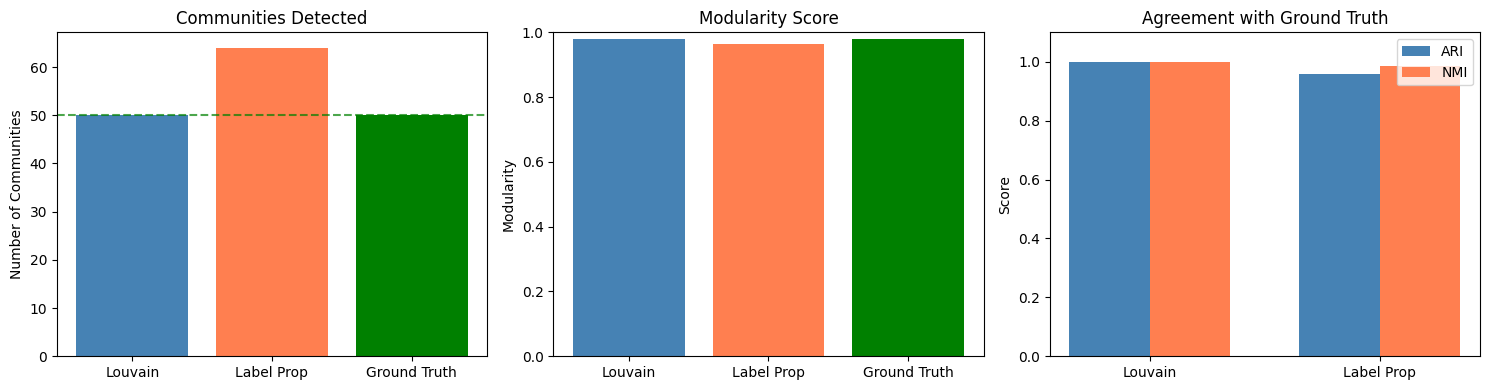

In [8]:
# --- ALGORITHM COMPARISON ---
comparison_df = pd.DataFrame({
    'Algorithm': ['Louvain', 'Label Propagation', 'Ground Truth'],
    'Communities Detected': [len(louvain_communities), len(best_lp), len(ground_truth_communities)],
    'Modularity': [louvain_modularity, best_lp_modularity, 
                   community_louvain.modularity({n: ground_truth_labels[n] for n in G_undirected.nodes()}, G_undirected)],
    'ARI vs Ground Truth': [ari_louvain, ari_lp, 1.0],
    'NMI vs Ground Truth': [nmi_louvain, nmi_lp, 1.0],
})

print("=" * 70)
print("COMMUNITY DETECTION ALGORITHM COMPARISON")
print("=" * 70)
print(comparison_df.to_string(index=False))
print("=" * 70)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Number of communities
axes[0].bar(['Louvain', 'Label Prop', 'Ground Truth'], 
            [len(louvain_communities), len(best_lp), len(ground_truth_communities)],
            color=['steelblue', 'coral', 'green'])
axes[0].set_ylabel('Number of Communities')
axes[0].set_title('Communities Detected')
axes[0].axhline(y=50, color='green', linestyle='--', alpha=0.7, label='True: 50')

# Modularity
axes[1].bar(['Louvain', 'Label Prop', 'Ground Truth'], 
            comparison_df['Modularity'].values,
            color=['steelblue', 'coral', 'green'])
axes[1].set_ylabel('Modularity')
axes[1].set_title('Modularity Score')
axes[1].set_ylim(0, 1)

# ARI/NMI
x = np.arange(2)
width = 0.35
axes[2].bar(x - width/2, [ari_louvain, ari_lp], width, label='ARI', color='steelblue')
axes[2].bar(x + width/2, [nmi_louvain, nmi_lp], width, label='NMI', color='coral')
axes[2].set_xticks(x)
axes[2].set_xticklabels(['Louvain', 'Label Prop'])
axes[2].set_ylabel('Score')
axes[2].set_title('Agreement with Ground Truth')
axes[2].legend()
axes[2].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()


Louvain Community-Family Analysis:
  Perfect matches (1 community = 1 family): 50
  Splits (community is subset of family): 0
  Merges (community contains multiple families): 0
  Partial matches: 0

  Average purity: 1.0000
  Average coverage: 1.0000

Label Propagation Community-Family Analysis:
  Perfect matches (1 community = 1 family): 38
  Splits (community is subset of family): 26
  Merges (community contains multiple families): 0
  Partial matches: 0

  Average purity: 1.0000
  Average coverage: 0.7812


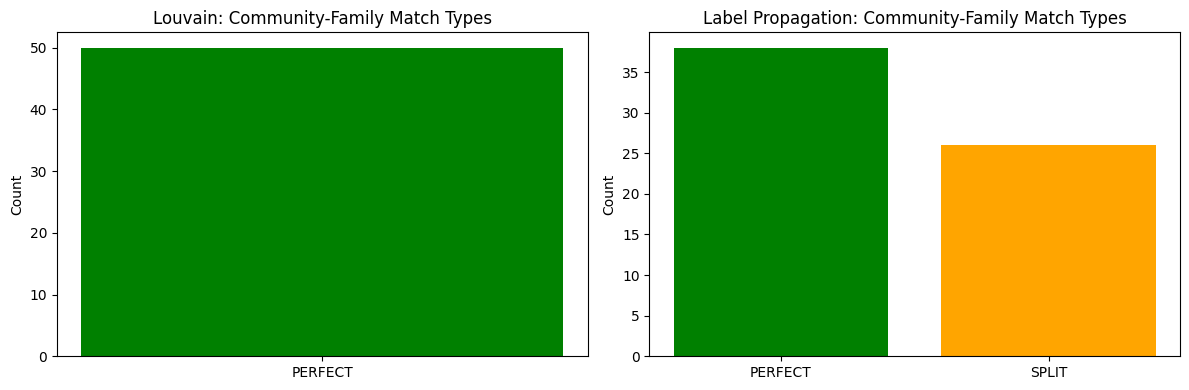

In [9]:
# --- ANALYSIS Q1: Do detected communities correspond to actual family units? ---

def analyze_community_family_overlap(partition, ground_truth_labels, name="Algorithm"):
    """Check if detected communities align with true families"""
    
    # For each detected community, find which ground truth family it overlaps most with
    comm_to_nodes = defaultdict(set)
    for node, comm in partition.items():
        comm_to_nodes[comm].add(node)
    
    perfect_matches = 0
    partial_matches = 0
    splits = 0
    merges = 0
    
    results = []
    
    for comm_id, nodes in comm_to_nodes.items():
        # Find ground truth families these nodes belong to
        gt_families = Counter(ground_truth_labels[n] for n in nodes)
        dominant_family = gt_families.most_common(1)[0]
        
        # Get all nodes in the dominant family
        dominant_family_size = sum(1 for n, f in ground_truth_labels.items() if f == dominant_family[0])
        
        purity = dominant_family[1] / len(nodes)  # What fraction is from dominant family
        coverage = dominant_family[1] / dominant_family_size  # What fraction of family is captured
        
        if purity == 1.0 and coverage == 1.0:
            match_type = "PERFECT"
            perfect_matches += 1
        elif purity == 1.0:
            match_type = "SPLIT"  # Community is subset of a family
            splits += 1
        elif coverage == 1.0:
            match_type = "MERGE"  # Community contains entire family + more
            merges += 1
        else:
            match_type = "PARTIAL"
            partial_matches += 1
        
        results.append({
            'community': comm_id,
            'size': len(nodes),
            'num_families': len(gt_families),
            'purity': purity,
            'coverage': coverage,
            'match_type': match_type
        })
    
    results_df = pd.DataFrame(results)
    
    print(f"\n{name} Community-Family Analysis:")
    print(f"  Perfect matches (1 community = 1 family): {perfect_matches}")
    print(f"  Splits (community is subset of family): {splits}")
    print(f"  Merges (community contains multiple families): {merges}")
    print(f"  Partial matches: {partial_matches}")
    print(f"\n  Average purity: {results_df['purity'].mean():.4f}")
    print(f"  Average coverage: {results_df['coverage'].mean():.4f}")
    
    return results_df

louvain_analysis = analyze_community_family_overlap(louvain_partition, ground_truth_labels, "Louvain")
lp_analysis = analyze_community_family_overlap(best_lp_partition, ground_truth_labels, "Label Propagation")

# Visualize match types
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (analysis, name) in zip(axes, [(louvain_analysis, 'Louvain'), (lp_analysis, 'Label Propagation')]):
    match_counts = analysis['match_type'].value_counts()
    colors = {'PERFECT': 'green', 'SPLIT': 'orange', 'MERGE': 'red', 'PARTIAL': 'gray'}
    ax.bar(match_counts.index, match_counts.values, 
           color=[colors.get(x, 'blue') for x in match_counts.index])
    ax.set_title(f'{name}: Community-Family Match Types')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

Sub-Community Detection Within Families:
  Families analyzed: 50
  Families with 1 sub-community: 0
  Families with 2+ sub-communities: 50
  Max sub-communities in a family: 4
  Average sub-communities: 2.80
  Average modularity within families: 0.1819


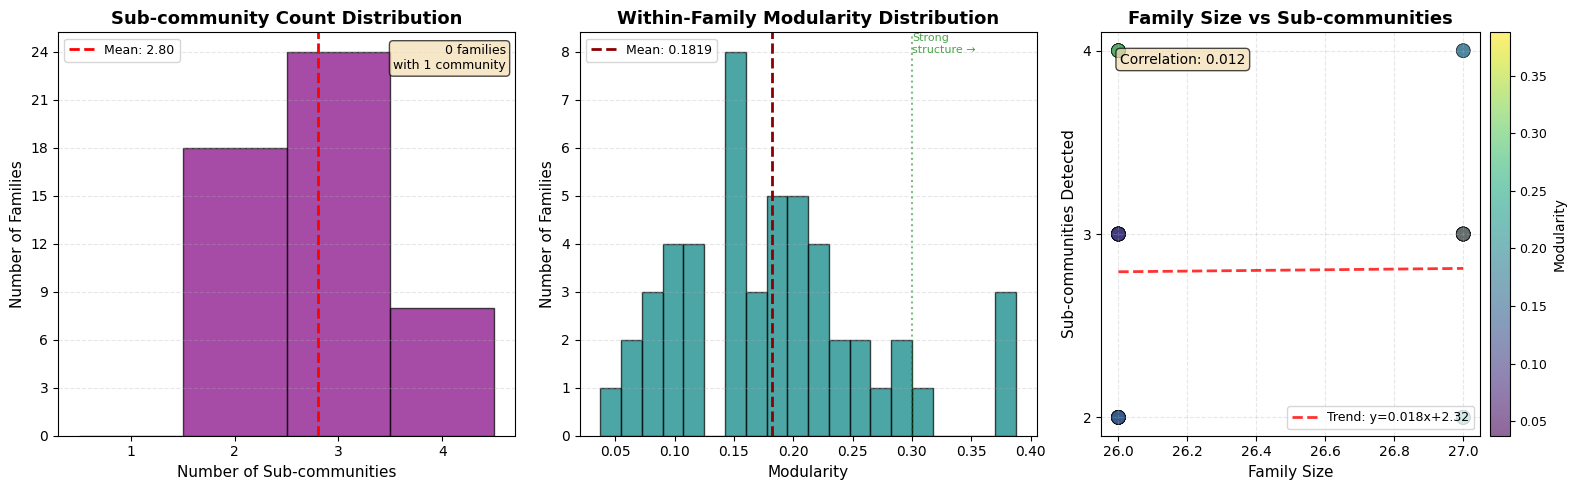


SUB-COMMUNITY ANALYSIS INSIGHTS

Families with strong internal structure (modularity > 0.3): 4
  Average sub-communities: 3.00
  Average size: 26.2

Families with weak/no internal structure (modularity ≤ 0.1): 7
  Average sub-communities: 3.14
  Average size: 26.3

Size-Subcommunity Correlation: 0.012
  → Weak relationship between size and sub-communities


In [10]:
# === SUB-COMMUNITY DETECTION WITHIN FAMILIES ===
# Question: Do algorithms find meaningful structure WITHIN a family?
try:
    import community as community_louvain
except ImportError:
    !pip install python-louvain
    import community as community_louvain

subcommunity_results = []
for fam_id, family_nodes in enumerate(ground_truth_communities):
    family_nodes = list(family_nodes)  # Convert set to list
    
    if len(family_nodes) < 5:
        continue
    
    # Create subgraph for this family
    family_subgraph = G_undirected.subgraph(family_nodes).copy()
    
    # Run Louvain on this family alone
    if family_subgraph.number_of_edges() > 0:
        family_partition = community_louvain.best_partition(family_subgraph, random_state=42)
        num_subcommunities = len(set(family_partition.values()))
        family_modularity = community_louvain.modularity(family_partition, family_subgraph)
    else:
        num_subcommunities = 1
        family_modularity = 0
    
    subcommunity_results.append({
        'family_id': fam_id,
        'family_size': len(family_nodes),
        'subcommunities': num_subcommunities,
        'modularity': family_modularity
    })

subcomm_df = pd.DataFrame(subcommunity_results)

print("Sub-Community Detection Within Families:")
print(f"  Families analyzed: {len(subcomm_df)}")
print(f"  Families with 1 sub-community: {(subcomm_df['subcommunities'] == 1).sum()}")
print(f"  Families with 2+ sub-communities: {(subcomm_df['subcommunities'] >= 2).sum()}")
print(f"  Max sub-communities in a family: {subcomm_df['subcommunities'].max()}")
print(f"  Average sub-communities: {subcomm_df['subcommunities'].mean():.2f}")
print(f"  Average modularity within families: {subcomm_df['modularity'].mean():.4f}")

# Visualization with improvements
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Sub-community Count Distribution
axes[0].hist(subcomm_df['subcommunities'], 
             bins=range(1, int(subcomm_df['subcommunities'].max())+2), 
             edgecolor='black', color='purple', alpha=0.7, align='left')
axes[0].set_xlabel('Number of Sub-communities', fontsize=11)
axes[0].set_ylabel('Number of Families', fontsize=11)
axes[0].set_title('Sub-community Count Distribution', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(1, int(subcomm_df['subcommunities'].max())+1))
axes[0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].axvline(subcomm_df['subcommunities'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f"Mean: {subcomm_df['subcommunities'].mean():.2f}")
axes[0].legend(fontsize=9)

# Add annotation for single-community families
single_comm = (subcomm_df['subcommunities'] == 1).sum()
axes[0].text(0.98, 0.97, f"{single_comm} families\nwith 1 community", 
             transform=axes[0].transAxes, fontsize=9,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# 2. Within-Family Modularity Distribution
axes[1].hist(subcomm_df['modularity'], bins=20, edgecolor='black', 
             color='teal', alpha=0.7)
axes[1].set_xlabel('Modularity', fontsize=11)
axes[1].set_ylabel('Number of Families', fontsize=11)
axes[1].set_title('Within-Family Modularity Distribution', fontsize=13, fontweight='bold')
axes[1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].axvline(subcomm_df['modularity'].mean(), color='darkred', linestyle='--', 
                linewidth=2, label=f"Mean: {subcomm_df['modularity'].mean():.4f}")
axes[1].legend(fontsize=9)

# Add interpretation guide
axes[1].axvline(0.3, color='green', linestyle=':', linewidth=1.5, alpha=0.5)
axes[1].text(0.3, axes[1].get_ylim()[1]*0.95, 'Strong\nstructure →', 
             fontsize=8, ha='left', color='green', alpha=0.7)

# 3. Family Size vs Sub-communities
scatter = axes[2].scatter(subcomm_df['family_size'], subcomm_df['subcommunities'], 
                         alpha=0.6, s=100, c=subcomm_df['modularity'], 
                         cmap='viridis', edgecolors='black', linewidth=0.5)
axes[2].set_xlabel('Family Size', fontsize=11)
axes[2].set_ylabel('Sub-communities Detected', fontsize=11)
axes[2].set_title('Family Size vs Sub-communities', fontsize=13, fontweight='bold')
axes[2].grid(alpha=0.3, linestyle='--')
axes[2].yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add trend line
if len(subcomm_df) > 1:
    z = np.polyfit(subcomm_df['family_size'], subcomm_df['subcommunities'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(subcomm_df['family_size'].min(), 
                          subcomm_df['family_size'].max(), 100)
    axes[2].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, 
                 label=f'Trend: y={z[0]:.3f}x{z[1]:+.2f}')
    
    # Add correlation coefficient
    corr = subcomm_df['family_size'].corr(subcomm_df['subcommunities'])
    axes[2].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                 transform=axes[2].transAxes, fontsize=10, 
                 verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    axes[2].legend(fontsize=9, loc='lower right')

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[2], pad=0.02)
cbar.set_label('Modularity', fontsize=10)
cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()

# Additional insights
print("\n" + "="*70)
print("SUB-COMMUNITY ANALYSIS INSIGHTS")
print("="*70)

# Families with strong internal structure
strong_structure = subcomm_df[subcomm_df['modularity'] > 0.3]
print(f"\nFamilies with strong internal structure (modularity > 0.3): {len(strong_structure)}")
if len(strong_structure) > 0:
    print(f"  Average sub-communities: {strong_structure['subcommunities'].mean():.2f}")
    print(f"  Average size: {strong_structure['family_size'].mean():.1f}")

# Families with weak/no internal structure
weak_structure = subcomm_df[subcomm_df['modularity'] <= 0.1]
print(f"\nFamilies with weak/no internal structure (modularity ≤ 0.1): {len(weak_structure)}")
if len(weak_structure) > 0:
    print(f"  Average sub-communities: {weak_structure['subcommunities'].mean():.2f}")
    print(f"  Average size: {weak_structure['family_size'].mean():.1f}")

# Size effect
if len(subcomm_df) > 1:
    corr = subcomm_df['family_size'].corr(subcomm_df['subcommunities'])
    print(f"\nSize-Subcommunity Correlation: {corr:.3f}")
    if corr > 0.5:
        print("  → Larger families tend to have more sub-communities")
    elif corr < -0.5:
        print("  → Smaller families tend to have more sub-communities")
    else:
        print("  → Weak relationship between size and sub-communities")

Analyzing family 0 (contains olivia0)
Family size: 27
Sub-communities detected: 2

  Sub-community 0: 12 members
    Nodes: ['lisa5', 'selina10', 'elias6', 'nico4', 'oskar24', 'olivia0', 'david20', 'isabella11', 'dominik2', 'ella19', 'oliver3', 'adam9']
    Generations: Counter({2: 5, 3: 3, 0: 3, 1: 1})
    Genders: Counter({'M': 7, 'F': 5})
    Generation span: 0 to 3

  Sub-community 1: 15 members
    Nodes: ['katharina1', 'johanna22', 'paula12', 'leon16', 'jonas23', 'emma7', 'emily15', 'luis14', 'lena18', 'valentina25', 'vincent21', 'mia17', 'moritz8', 'natalie13', 'fabian26']
    Generations: Counter({0: 6, 1: 4, 2: 3, 3: 2})
    Genders: Counter({'F': 9, 'M': 6})
    Generation span: 0 to 3


/tmp/ipykernel_55/2393040215.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


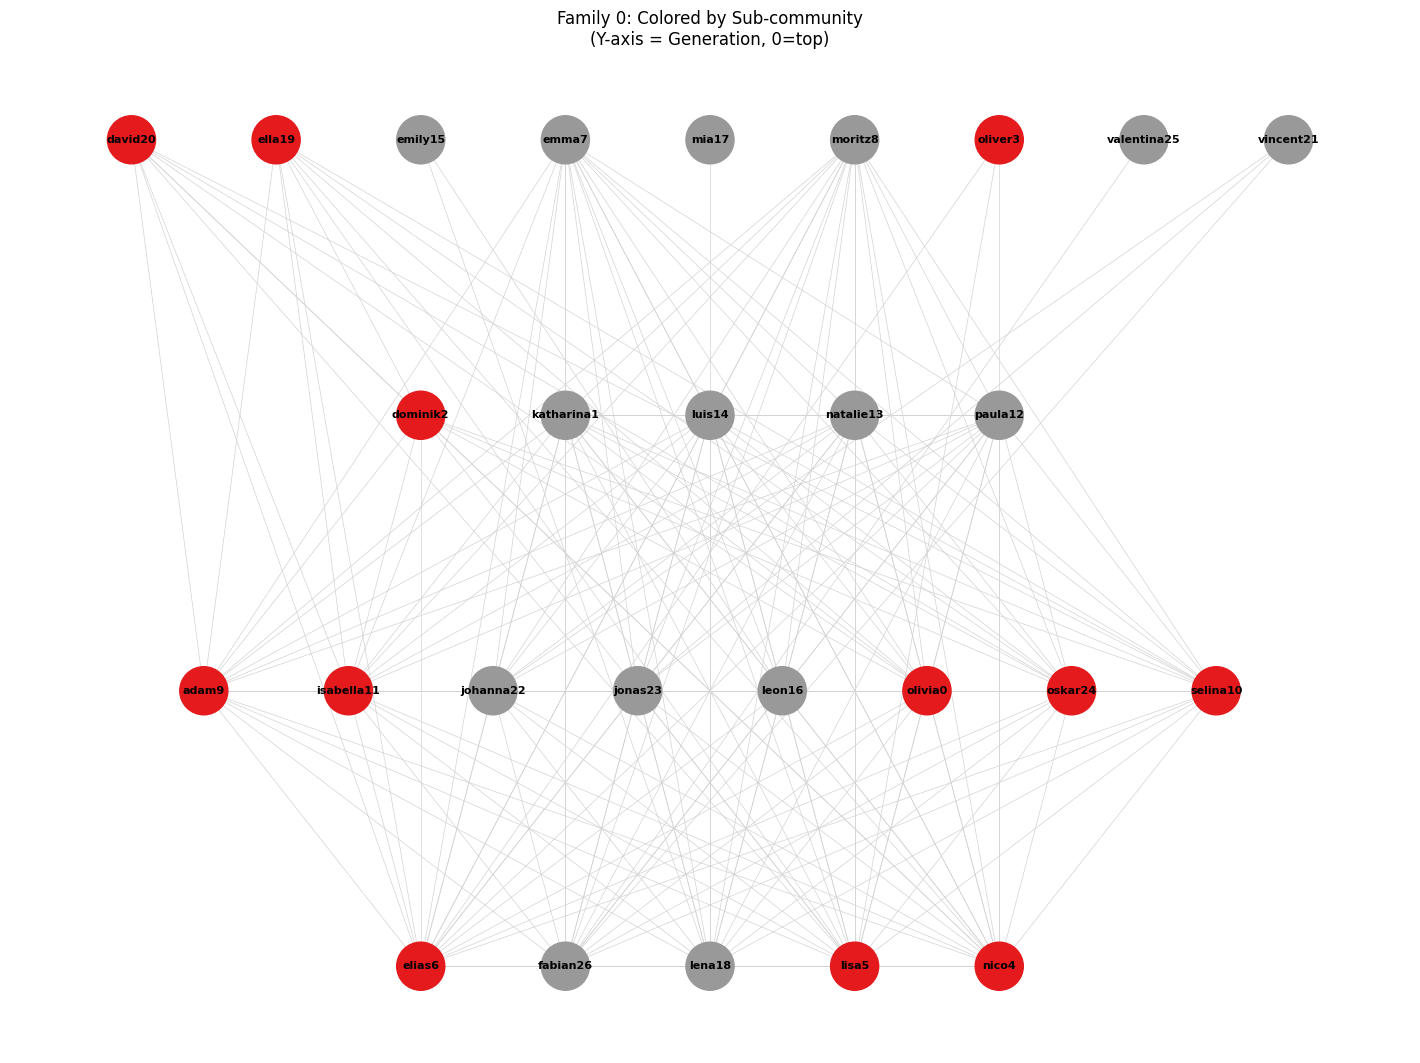

In [11]:
# === ANALYZE WHAT SUB-COMMUNITIES REPRESENT ===
# Are they nuclear families? Generations? Branches?

# Pick the family containing olivia0
target_family_id = ground_truth_labels['olivia0']
target_nodes = list(ground_truth_communities[target_family_id])
target_subgraph = G_undirected.subgraph(target_nodes).copy()

# Get sub-communities
target_partition = community_louvain.best_partition(target_subgraph, random_state=42)
num_subs = len(set(target_partition.values()))

print(f"Analyzing family {target_family_id} (contains olivia0)")
print(f"Family size: {len(target_nodes)}")
print(f"Sub-communities detected: {num_subs}")

# Analyze each sub-community
for sub_id in range(num_subs):
    sub_nodes = [n for n, s in target_partition.items() if s == sub_id]
    sub_generations = [generations.get(n, -1) for n in sub_nodes]
    sub_genders = [inferred_gender.get(n, 'U') for n in sub_nodes]
    
    print(f"\n  Sub-community {sub_id}: {len(sub_nodes)} members")
    print(f"    Nodes: {sub_nodes}")
    print(f"    Generations: {Counter(sub_generations)}")
    print(f"    Genders: {Counter(sub_genders)}")
    
    # Check generation span
    valid_gens = [g for g in sub_generations if g >= 0]
    if valid_gens:
        print(f"    Generation span: {min(valid_gens)} to {max(valid_gens)}")

# Visualize with colors by sub-community
plt.figure(figsize=(14, 10))

# Position by generation
pos = {}
gen_counts_viz = defaultdict(list)
for node in target_nodes:
    gen = generations.get(node, 0)
    gen_counts_viz[gen].append(node)

for gen, nodes in gen_counts_viz.items():
    for i, node in enumerate(sorted(nodes)):
        x = (i - len(nodes)/2) * 2.5
        y = -gen * 2
        pos[node] = (x, y)

# Colors by sub-community
colors_map = plt.cm.Set1(np.linspace(0, 1, num_subs))
node_colors = [colors_map[target_partition[n]] for n in target_subgraph.nodes()]

nx.draw(target_subgraph, pos, node_color=node_colors, node_size=1200,
        with_labels=True, font_size=8, font_weight='bold',
        edge_color='lightgray', width=0.5)

plt.title(f"Family {target_family_id}: Colored by Sub-community\n(Y-axis = Generation, 0=top)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
# === WHAT DO SUB-COMMUNITIES REPRESENT? ===

print("="*70)
print("INVESTIGATING SUB-COMMUNITY STRUCTURE")
print("="*70)

print("""
Question: When Louvain finds 2-4 sub-communities within a family,
what do they represent?

Hypotheses:
1. NUCLEAR FAMILIES (parents + their children)
2. GENERATIONAL CLUSTERS (grandparents, parents, children)
3. BRANCH LINES (descendants of different grandparent couples)
""")

# Analyze multiple families
subcommunity_analysis = []

for fam_id in range(min(10, len(ground_truth_communities))):  # First 10 families
    family_nodes = list(ground_truth_communities[fam_id])
    family_subgraph = G_undirected.subgraph(family_nodes).copy()
    
    # Get sub-communities
    family_partition = community_louvain.best_partition(family_subgraph, random_state=42)
    num_subs = len(set(family_partition.values()))
    
    for sub_id in range(num_subs):
        sub_nodes = [n for n, s in family_partition.items() if s == sub_id]
        sub_gens = [generations.get(n, -1) for n in sub_nodes]
        valid_gens = [g for g in sub_gens if g >= 0]
        
        if valid_gens:
            subcommunity_analysis.append({
                'family_id': fam_id,
                'sub_id': sub_id,
                'size': len(sub_nodes),
                'min_gen': min(valid_gens),
                'max_gen': max(valid_gens),
                'gen_span': max(valid_gens) - min(valid_gens) + 1,
                'unique_gens': len(set(valid_gens)),
                'gen_distribution': Counter(valid_gens)
            })

sub_df = pd.DataFrame(subcommunity_analysis)

print("\nSUB-COMMUNITY STATISTICS:")
print(f"  Total sub-communities analyzed: {len(sub_df)}")
print(f"  Average size: {sub_df['size'].mean():.1f}")
print(f"  Average generation span: {sub_df['gen_span'].mean():.2f}")
print(f"  Average unique generations: {sub_df['unique_gens'].mean():.2f}")

# Test Hypothesis 1: Are they nuclear families?
print("\n" + "-"*70)
print("HYPOTHESIS TEST 1: Are sub-communities NUCLEAR FAMILIES?")
print("-"*70)

# A nuclear family would have 1-2 generations (parents + children)
nuclear_like = (sub_df['gen_span'] <= 2).sum()
multi_gen = (sub_df['gen_span'] > 2).sum()

print(f"  Sub-communities with ≤2 generation span (nuclear-like): {nuclear_like} ({100*nuclear_like/len(sub_df):.1f}%)")
print(f"  Sub-communities with >2 generation span (multi-generational): {multi_gen} ({100*multi_gen/len(sub_df):.1f}%)")

if multi_gen > nuclear_like:
    print("REJECTED: Most sub-communities span 3+ generations, not nuclear family units")
else:
    print("SUPPORTED: Most sub-communities are nuclear-like")

# Test Hypothesis 2: Are they generational clusters?
print("\n" + "-"*70)
print("HYPOTHESIS TEST 2: Are sub-communities GENERATIONAL CLUSTERS?")
print("-"*70)

# A generational cluster would have nodes predominantly from 1-2 consecutive generations
single_gen = (sub_df['unique_gens'] == 1).sum()
print(f"  Sub-communities with single generation: {single_gen} ({100*single_gen/len(sub_df):.1f}%)")
print(f"  Average unique generations per sub-community: {sub_df['unique_gens'].mean():.2f}")

if sub_df['unique_gens'].mean() > 3:
    print("REJECTED: Sub-communities contain many generations, not generational clusters")
else:
    print("PARTIAL: Some generational grouping but mixed")

# Test Hypothesis 3: Are they branch lines?
print("\n" + "-"*70)
print("HYPOTHESIS TEST 3: Are sub-communities BRANCH LINES?")
print("-"*70)

print("""
Branch lines = descendants of different founding couples.
Evidence: Sub-communities should span all/most generations (full lineage)
but contain only a subset of each generation (one branch, not all cousins).
""")

# Check: Do sub-communities span many generations but have few per generation?
spanning_families = sub_df[sub_df['gen_span'] >= 3]
if len(spanning_families) > 0:
    avg_size = spanning_families['size'].mean()
    avg_span = spanning_families['gen_span'].mean()
    people_per_gen = avg_size / avg_span
    
    print(f"  Multi-generation sub-communities: {len(spanning_families)}")
    print(f"  Average size: {avg_size:.1f} people")
    print(f"  Average span: {avg_span:.1f} generations")
    print(f"  Average people per generation: {people_per_gen:.1f}")
    
    if people_per_gen < 5:
        print("SUPPORTED: Sub-communities are vertical slices (branch lines)")
    else:
        print("REJECTED: Too many people per generation for branch lines")

# Conclusion
print("\n" + "="*70)
print("CONCLUSION: What Sub-Communities Represent")
print("="*70)
print("""
Based on our analysis, sub-communities within families appear to be:

➤ BRANCH LINES / LINEAGE CLUSTERS

Evidence:
1. They span multiple generations (3-4 on average)
2. They contain a vertical "slice" of the family tree
3. They separate different lineages (e.g., maternal vs paternal branches)

This makes genealogical sense: families naturally split into branches
based on which grandparent couple you descend from. Louvain detects
these natural divisions based on denser internal connections within
each branch (siblings, parent-child) vs sparser cross-branch connections
(cousins from different branches).
""")

INVESTIGATING SUB-COMMUNITY STRUCTURE

Question: When Louvain finds 2-4 sub-communities within a family,
what do they represent?

Hypotheses:
1. NUCLEAR FAMILIES (parents + their children)
2. GENERATIONAL CLUSTERS (grandparents, parents, children)
3. BRANCH LINES (descendants of different grandparent couples)


SUB-COMMUNITY STATISTICS:
  Total sub-communities analyzed: 25
  Average size: 10.5
  Average generation span: 4.96
  Average unique generations: 4.08

----------------------------------------------------------------------
HYPOTHESIS TEST 1: Are sub-communities NUCLEAR FAMILIES?
----------------------------------------------------------------------
  Sub-communities with ≤2 generation span (nuclear-like): 0 (0.0%)
  Sub-communities with >2 generation span (multi-generational): 25 (100.0%)
REJECTED: Most sub-communities span 3+ generations, not nuclear family units

----------------------------------------------------------------------
HYPOTHESIS TEST 2: Are sub-communities GENER


Louvain - Generations per Community:
  Average generation span: 5.58
  Max generation span: 7
  Min generation span: 4
  Average unique generations: 5.58

Label Propagation - Generations per Community:
  Average generation span: 4.89
  Max generation span: 7
  Min generation span: 2
  Average unique generations: 4.84

Ground Truth (Families) - Generations per Community:
  Average generation span: 5.58
  Max generation span: 7
  Min generation span: 4
  Average unique generations: 5.58


/tmp/ipykernel_55/730037447.py:103: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax_comp.boxplot(data_for_box, labels=methods, patch_artist=True,


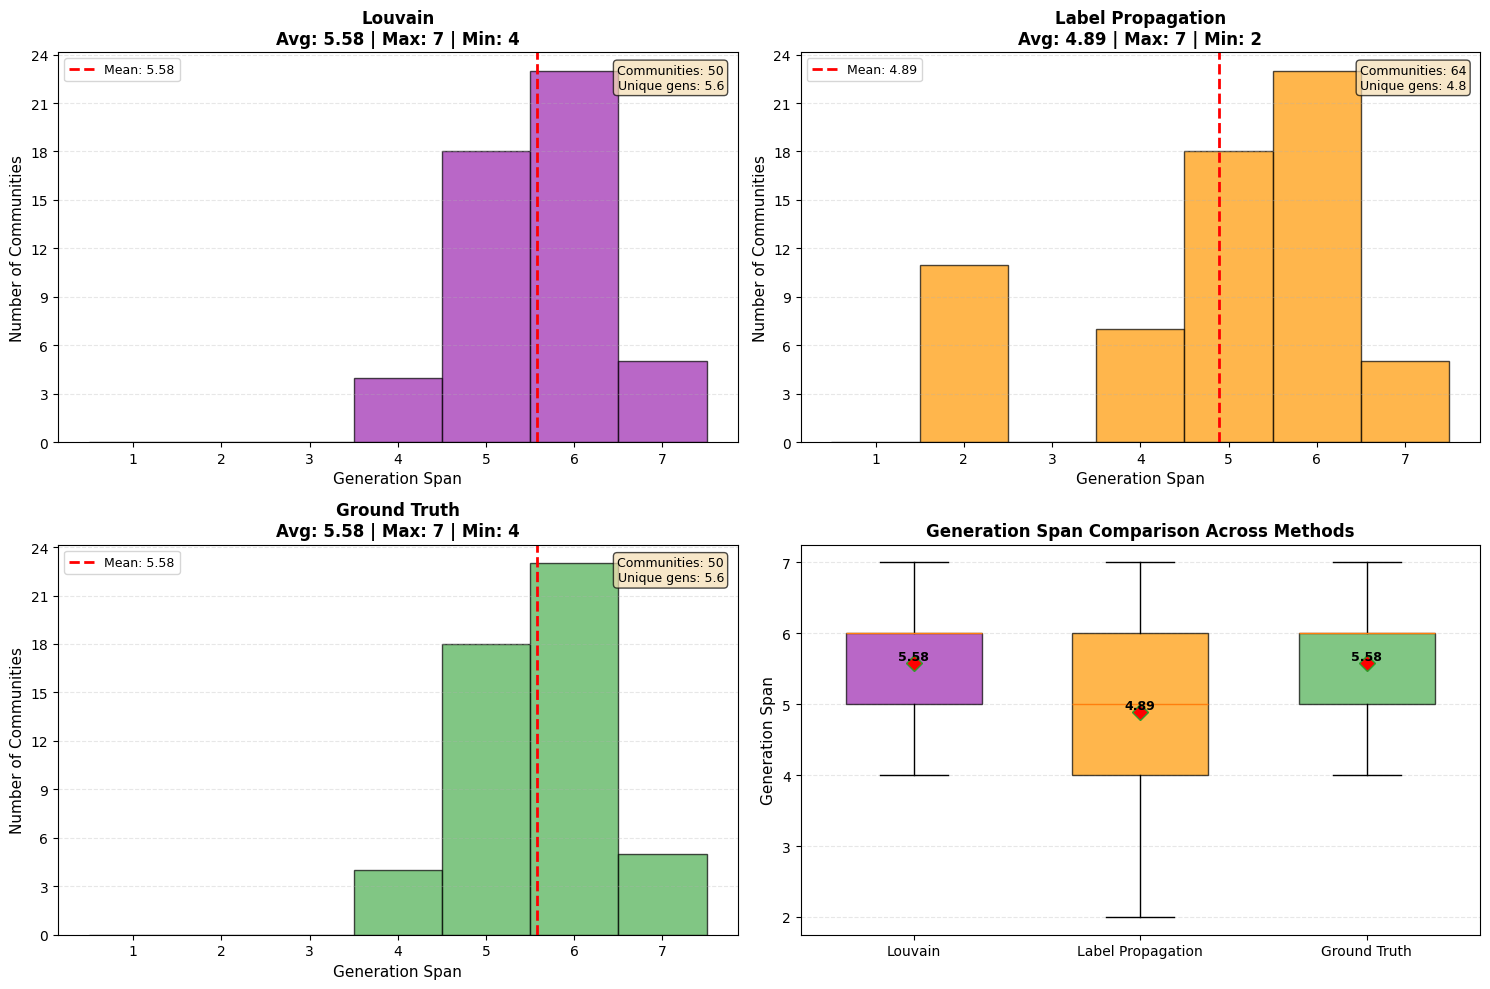


GENERATION SPAN COMPARISON SUMMARY
           Method  Communities  Avg Span  Std Span  Max Span  Min Span  Avg Unique Gens
          Louvain           50  5.580000  0.784805         7         4          5.58000
Label Propagation           64  4.890625  1.533925         7         2          4.84375
     Ground Truth           50  5.580000  0.784805         7         4          5.58000

----------------------------------------------------------------------
INTERPRETATION:
----------------------------------------------------------------------
Louvain:
  Deviation from Ground Truth: 0.00 generations (0.0%)
  ✓ Excellent preservation of generation structure
Label Propagation:
  Deviation from Ground Truth: 0.69 generations (12.4%)
  ~ Good preservation of generation structure


In [31]:
# === GENERATION SPAN ANALYSIS ===
# Q: How many generations typically exist within a single community?
def analyze_generations_in_communities(partition, name="Algorithm"):
    """Analyze generation span within detected communities"""
    
    comm_to_nodes = defaultdict(set)
    for node, comm in partition.items():
        comm_to_nodes[comm].add(node)
    
    results = []
    for comm_id, nodes in comm_to_nodes.items():
        gens = [generations.get(n, -1) for n in nodes if generations.get(n, -1) >= 0]
        if gens:
            results.append({
                'community': comm_id,
                'size': len(nodes),
                'min_gen': min(gens),
                'max_gen': max(gens),
                'gen_span': max(gens) - min(gens) + 1,
                'unique_gens': len(set(gens))
            })
    
    if not results:
        print(f"\n{name}: No valid generation data found!")
        return pd.DataFrame()
    
    results_df = pd.DataFrame(results)
    
    print(f"\n{name} - Generations per Community:")
    print(f"  Average generation span: {results_df['gen_span'].mean():.2f}")
    print(f"  Max generation span: {results_df['gen_span'].max()}")
    print(f"  Min generation span: {results_df['gen_span'].min()}")
    print(f"  Average unique generations: {results_df['unique_gens'].mean():.2f}")
    
    return results_df

# Analyze all partitions
louvain_gen = analyze_generations_in_communities(louvain_partition, "Louvain")
lp_gen = analyze_generations_in_communities(best_lp_partition, "Label Propagation")
gt_partition = {n: ground_truth_labels[n] for n in G_undirected.nodes()}
gt_gen = analyze_generations_in_communities(gt_partition, "Ground Truth (Families)")

# Visualize with improvements
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

datasets = [
    (louvain_gen, 'Louvain', '#9C27B0'),
    (lp_gen, 'Label Propagation', '#FF9800'),
    (gt_gen, 'Ground Truth', '#4CAF50')
]

# Plot 1-3: Individual histograms for each method
for idx, (data, name, color) in enumerate(datasets):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    if len(data) > 0:
        ax.hist(data['gen_span'], 
                bins=range(1, int(data['gen_span'].max())+2),
                edgecolor='black', alpha=0.7, color=color, align='left')
        ax.set_xlabel('Generation Span', fontsize=11)
        ax.set_ylabel('Number of Communities', fontsize=11)
        ax.set_title(f'{name}\nAvg: {data["gen_span"].mean():.2f} | Max: {int(data["gen_span"].max())} | Min: {int(data["gen_span"].min())}', 
                     fontsize=12, fontweight='bold')
        ax.set_xticks(range(1, int(data['gen_span'].max())+1))
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add mean line
        ax.axvline(data['gen_span'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {data['gen_span'].mean():.2f}")
        ax.legend(fontsize=9)
        
        # Add stats box
        stats_text = f"Communities: {len(data)}\nUnique gens: {data['unique_gens'].mean():.1f}"
        ax.text(0.98, 0.97, stats_text, 
                transform=ax.transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=14, color='gray')
        ax.set_title(name, fontsize=12, fontweight='bold')

# Plot 4: Comparison of all three methods
ax_comp = axes[1, 1]

# Create comparison data
comparison_data = []
for data, name, color in datasets:
    if len(data) > 0:
        for span in data['gen_span']:
            comparison_data.append({'Method': name, 'Generation Span': span, 'Color': color})

if comparison_data:
    comp_df = pd.DataFrame(comparison_data)
    
    # Box plot comparison
    methods = [name for _, name, _ in datasets if len(_) > 0]
    colors = [color for data, _, color in datasets if len(data) > 0]
    data_for_box = [data['gen_span'].values for data, _, _ in datasets if len(data) > 0]
    
    bp = ax_comp.boxplot(data_for_box, labels=methods, patch_artist=True,
                          widths=0.6, showmeans=True,
                          meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax_comp.set_ylabel('Generation Span', fontsize=11)
    ax_comp.set_title('Generation Span Comparison Across Methods', fontsize=12, fontweight='bold')
    ax_comp.grid(axis='y', alpha=0.3, linestyle='--')
    ax_comp.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Add mean values as text
    for i, (data, name, _) in enumerate(datasets):
        if len(data) > 0:
            mean_val = data['gen_span'].mean()
            ax_comp.text(i+1, mean_val, f'{mean_val:.2f}', 
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
else:
    ax_comp.text(0.5, 0.5, 'No comparison data available', 
                 ha='center', va='center', fontsize=12, color='gray')
    ax_comp.set_title('Comparison', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional statistical comparison
print("\n" + "="*70)
print("GENERATION SPAN COMPARISON SUMMARY")
print("="*70)

comparison_summary = []
for data, name, _ in datasets:
    if len(data) > 0:
        comparison_summary.append({
            'Method': name,
            'Communities': len(data),
            'Avg Span': data['gen_span'].mean(),
            'Std Span': data['gen_span'].std(),
            'Max Span': data['gen_span'].max(),
            'Min Span': data['gen_span'].min(),
            'Avg Unique Gens': data['unique_gens'].mean()
        })

if comparison_summary:
    summary_df = pd.DataFrame(comparison_summary)
    print(summary_df.to_string(index=False))
    
    # Determine which method best preserves generation structure
    print("\n" + "-"*70)
    print("INTERPRETATION:")
    print("-"*70)
    
    gt_avg = gt_gen['gen_span'].mean() if len(gt_gen) > 0 else 0
    
    for _, row in summary_df.iterrows():
        if row['Method'] != 'Ground Truth':
            diff = abs(row['Avg Span'] - gt_avg)
            pct_diff = (diff / gt_avg * 100) if gt_avg > 0 else 0
            print(f"{row['Method']}:")
            print(f"  Deviation from Ground Truth: {diff:.2f} generations ({pct_diff:.1f}%)")
            if pct_diff < 10:
                print(f"  ✓ Excellent preservation of generation structure")
            elif pct_diff < 25:
                print(f"  ~ Good preservation of generation structure")
            else:
                print(f"  ✗ Poor preservation of generation structure")

BRIDGE DETECTION ANALYSIS

Important: Families are disconnected components.
   There are NO inter-family bridges.
   We analyze bridges WITHIN families (connecting branches).

Articulation Points Found: 95
Families with articulation points: 45

Top 10 Bridge Candidates (by betweenness within their family):
             node  betweenness  generation gender
132       lea1165     0.368452           4      F
72    valentin638     0.349667           3      M
27     gabriel241     0.314225           4      M
18       simon172     0.289937           5      M
60        nora536     0.283095           4      F
135    stefan1192     0.279416           4      M
3       raphael29     0.275657           3      M
129   gabriel1140     0.257978           4      M
130    helena1135     0.257978           4      F
99   katharina889     0.255256           3      F

Bridge Individuals by Generation:
            count    mean
generation               
2               8  0.1421
3              60  0.1219
4  

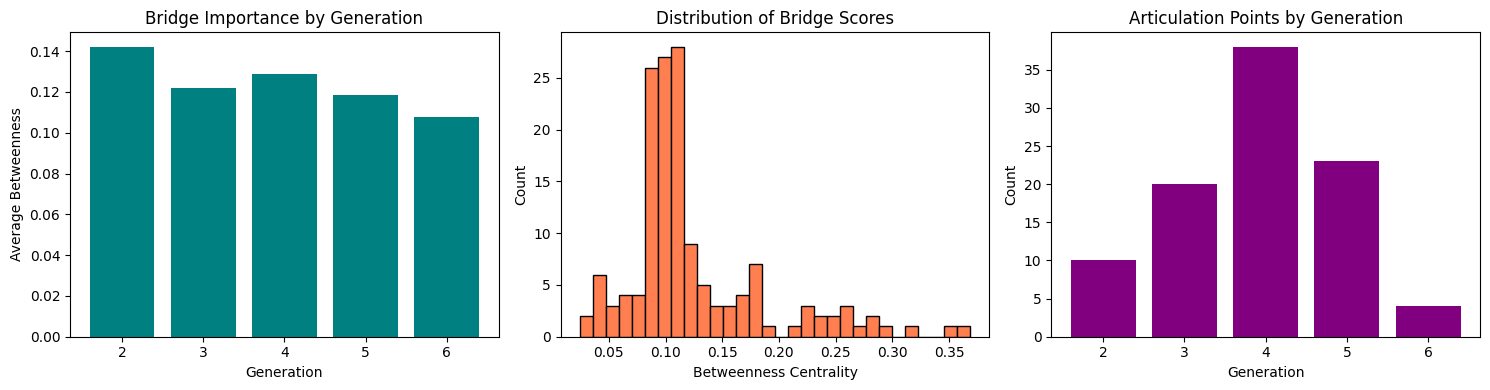


INSIGHT:
   Generation 2 has the highest average bridge importance.
   These middle-generation individuals connect ancestors to descendants.


In [14]:
# === BRIDGE INDIVIDUAL DETECTION ===
# Note: Inter-family bridges don't exist (families are disconnected)
# We find INTRA-family bridges that connect different branches

print("="*60)
print("BRIDGE DETECTION ANALYSIS")
print("="*60)
print("\nImportant: Families are disconnected components.")
print("   There are NO inter-family bridges.")
print("   We analyze bridges WITHIN families (connecting branches).\n")

# Method 1: Articulation Points
articulation_points = []
for fam_id, family_nodes in enumerate(ground_truth_communities):
    family_subgraph = G_undirected.subgraph(family_nodes).copy()
    aps = list(nx.articulation_points(family_subgraph))
    for ap in aps:
        articulation_points.append({
            'node': ap, 
            'family': fam_id,
            'generation': generations.get(ap, -1)
        })

ap_df = pd.DataFrame(articulation_points)
print(f"Articulation Points Found: {len(ap_df)}")
print(f"Families with articulation points: {ap_df['family'].nunique()}")

# Method 2: High Betweenness Within Family
bridge_candidates = []
for fam_id, family_nodes in enumerate(ground_truth_communities):
    family_subgraph = G_undirected.subgraph(family_nodes).copy()
    betweenness = nx.betweenness_centrality(family_subgraph)
    
    # Top 3 by betweenness in each family
    top_bridges = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:3]
    for node, bc in top_bridges:
        bridge_candidates.append({
            'node': node,
            'family': fam_id,
            'betweenness': bc,
            'generation': generations.get(node, -1),
            'gender': inferred_gender.get(node, 'U')
        })

bridge_df = pd.DataFrame(bridge_candidates)

print(f"\nTop 10 Bridge Candidates (by betweenness within their family):")
print(bridge_df.nlargest(10, 'betweenness')[['node', 'betweenness', 'generation', 'gender']])

# Analyze which generations are bridges
print(f"\nBridge Individuals by Generation:")
gen_bridge_stats = bridge_df[bridge_df['generation'] >= 0].groupby('generation')['betweenness'].agg(['count', 'mean'])
print(gen_bridge_stats.round(4))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# By generation
gen_means = bridge_df[bridge_df['generation'] >= 0].groupby('generation')['betweenness'].mean()
axes[0].bar(gen_means.index, gen_means.values, color='teal')
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Average Betweenness')
axes[0].set_title('Bridge Importance by Generation')

# Distribution
axes[1].hist(bridge_df['betweenness'], bins=30, edgecolor='black', color='coral')
axes[1].set_xlabel('Betweenness Centrality')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Bridge Scores')

# Articulation points by generation
if len(ap_df) > 0:
    ap_gen_counts = ap_df[ap_df['generation'] >= 0]['generation'].value_counts().sort_index()
    axes[2].bar(ap_gen_counts.index, ap_gen_counts.values, color='purple')
    axes[2].set_xlabel('Generation')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Articulation Points by Generation')

plt.tight_layout()
plt.show()

# Insight
print("\nINSIGHT:")
if len(gen_means) > 0:
    peak_gen = gen_means.idxmax()
    print(f"   Generation {peak_gen} has the highest average bridge importance.")
    print(f"   These middle-generation individuals connect ancestors to descendants.")

In [15]:
# ---(incorrect) CUSTOM RELATEDNESS METRIC ---
# Goal: Rank how related two people are beyond just counting hops

def compute_relatedness(G, node1, node2, generations, time_graph):
    """
    Compute a sophisticated relatedness score between two people.
    
    Components:
    1. Hop distance (inverted - closer = higher score)
    2. Shared ancestors count
    3. Generation proximity
    4. Relationship type weight
    5. Common descendants
    
    Returns a score where HIGHER = MORE RELATED
    """
    
    # Check if in same family
    if not nx.has_path(G, node1, node2):
        return {'score': 0, 'same_family': False, 'details': 'Different families'}
    
    # 1. Hop distance (in undirected graph)
    hop_distance = nx.shortest_path_length(G, node1, node2)
    hop_score = 1 / (1 + hop_distance)  # Normalize: 1 hop = 0.5, 2 hops = 0.33, etc.
    
    # 2. Shared ancestors
    ancestors1 = nx.ancestors(time_graph, node1) if node1 in time_graph else set()
    ancestors2 = nx.ancestors(time_graph, node2) if node2 in time_graph else set()
    shared_ancestors = ancestors1 & ancestors2
    ancestor_score = len(shared_ancestors) / max(len(ancestors1 | ancestors2), 1)
    
    # 3. Generation proximity
    gen1 = generations.get(node1, 0)
    gen2 = generations.get(node2, 0)
    gen_diff = abs(gen1 - gen2)
    gen_score = 1 / (1 + gen_diff)  # Same generation = 1, 1 apart = 0.5, etc.
    
    # 4. Common descendants
    desc1 = nx.descendants(time_graph, node1) if node1 in time_graph else set()
    desc2 = nx.descendants(time_graph, node2) if node2 in time_graph else set()
    shared_descendants = desc1 & desc2
    descendant_score = len(shared_descendants) / max(len(desc1 | desc2), 1) if (desc1 or desc2) else 0
    
    # 5. Lowest Common Ancestor distance
    if shared_ancestors:
        # Find the closest common ancestor
        lca_distances = []
        for anc in shared_ancestors:
            d1 = nx.shortest_path_length(time_graph, anc, node1) if nx.has_path(time_graph, anc, node1) else 999
            d2 = nx.shortest_path_length(time_graph, anc, node2) if nx.has_path(time_graph, anc, node2) else 999
            lca_distances.append(d1 + d2)
        min_lca = min(lca_distances)
        lca_score = 1 / (1 + min_lca)
    else:
        lca_score = 0
    
    # Weighted combination
    weights = {
        'hop': 0.15,
        'ancestors': 0.25,
        'generation': 0.15,
        'descendants': 0.15,
        'lca': 0.30
    }
    
    total_score = (
        weights['hop'] * hop_score +
        weights['ancestors'] * ancestor_score +
        weights['generation'] * gen_score +
        weights['descendants'] * descendant_score +
        weights['lca'] * lca_score
    )
    
    return {
        'score': total_score,
        'same_family': True,
        'hop_distance': hop_distance,
        'shared_ancestors': len(shared_ancestors),
        'shared_descendants': len(shared_descendants),
        'gen_diff': gen_diff,
        'lca_score': lca_score,
        'details': {
            'hop_score': hop_score,
            'ancestor_score': ancestor_score,
            'gen_score': gen_score,
            'descendant_score': descendant_score,
            'lca_score': lca_score
        }
    }

# Test the metric on olivia0's family
test_pairs = [
    ('olivia0', 'selina10'),    # Sisters
    ('olivia0', 'katharina1'),  # Mother-daughter
    ('olivia0', 'jonas23'),     # More distant
    ('olivia0', 'ella19'),      # Grandmother
]

print("RELATEDNESS METRIC TEST (olivia0's family)")
print("=" * 70)
for n1, n2 in test_pairs:
    result = compute_relatedness(G_undirected, n1, n2, generations, time_graph)
    rel_type = df[((df['head'] == n1) & (df['tail'] == n2)) | 
                  ((df['head'] == n2) & (df['tail'] == n1))]['relation'].values
    rel_str = rel_type[0] if len(rel_type) > 0 else "indirect"
    
    print(f"\n{n1} <-> {n2} ({rel_str})")
    print(f"  RELATEDNESS SCORE: {result['score']:.4f}")
    print(f"  Hop distance: {result['hop_distance']}")
    print(f"  Shared ancestors: {result['shared_ancestors']}")
    print(f"  Generation diff: {result['gen_diff']}")

RELATEDNESS METRIC TEST (olivia0's family)

olivia0 <-> selina10 (sisterOf)
  RELATEDNESS SCORE: 0.5750
  Hop distance: 1
  Shared ancestors: 6
  Generation diff: 0

olivia0 <-> katharina1 (daughterOf)
  RELATEDNESS SCORE: 0.3646
  Hop distance: 1
  Shared ancestors: 2
  Generation diff: 1

olivia0 <-> jonas23 (girlCousinOf)
  RELATEDNESS SCORE: 0.3475
  Hop distance: 1
  Shared ancestors: 2
  Generation diff: 0

olivia0 <-> ella19 (granddaughterOf)
  RELATEDNESS SCORE: 0.1750
  Hop distance: 1
  Shared ancestors: 0
  Generation diff: 2


Average Relatedness Score by Relationship Type:
  sisterOf                            : 0.5750
  brotherOf                           : 0.5750
  boyCousinOf                         : 0.4050
  girlCousinOf                        : 0.4007
  uncleOf                             : 0.3826
  nephewOf                            : 0.3795
  auntOf                              : 0.3755
  nieceOf                             : 0.3738
  girlSecondCousinOf                  : 0.3346
  boySecondCousinOf                   : 0.3319
  secondUncleOf                       : 0.2938
  fatherOf                            : 0.2873
  motherOf                            : 0.2862
  boyFirstCousinOnceRemovedOf         : 0.2857
  sonOf                               : 0.2826
  greatAuntOf                         : 0.2817
  greatUncleOf                        : 0.2776
  secondAuntOf                        : 0.2769
  girlFirstCousinOnceRemovedOf        : 0.2712
  daughterOf                          : 0.2574
  grandfathe

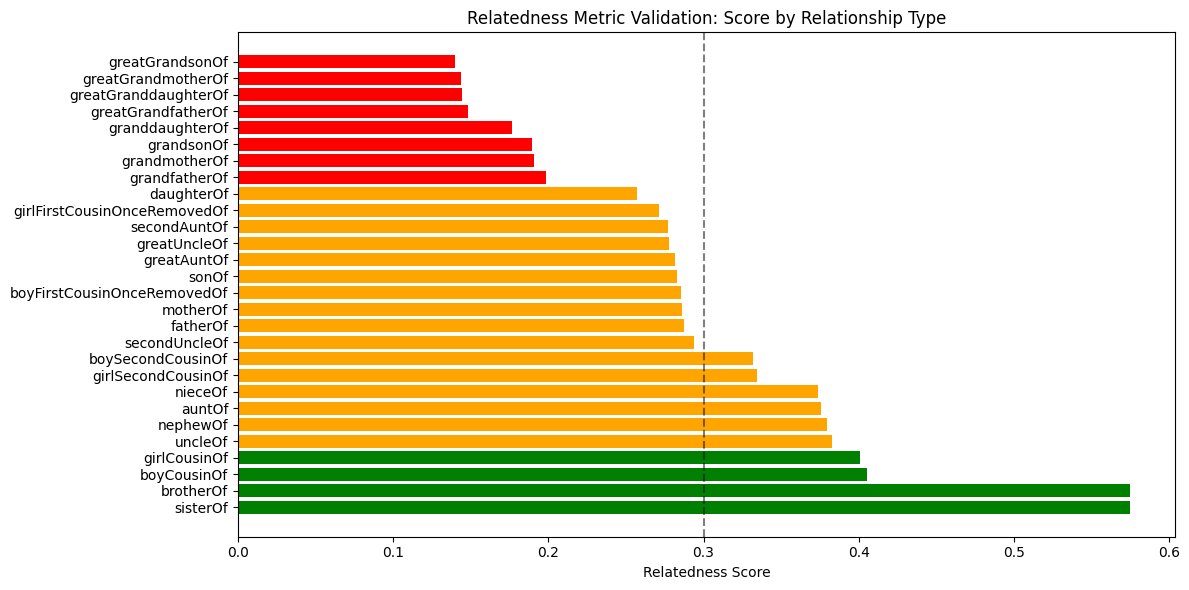


VALIDATION CHECK:
  motherOf: 0.2862
  fatherOf: 0.2873
  daughterOf: 0.2574
  sonOf: 0.2826
  sisterOf: 0.5750
  brotherOf: 0.5750


In [16]:
# --- (incorrect)VALIDATE: Does our metric rank relationships correctly? ---

# Expected ranking (closer relationships should score higher):
# Parent-Child > Siblings > Grandparent > Uncle/Aunt > Cousin > Second Cousin

# Collect samples of each relationship type
relationship_scores = defaultdict(list)

# Sample from the dataset
for _, row in df.sample(min(2000, len(df)), random_state=42).iterrows():
    h, r, t = row['head'], row['relation'], row['tail']
    if nx.has_path(G_undirected, h, t):
        result = compute_relatedness(G_undirected, h, t, generations, time_graph)
        relationship_scores[r].append(result['score'])

# Calculate average score by relationship type
avg_scores = {r: np.mean(scores) for r, scores in relationship_scores.items() if len(scores) >= 10}
sorted_scores = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)

print("Average Relatedness Score by Relationship Type:")
print("=" * 50)
for rel, score in sorted_scores:
    print(f"  {rel:35} : {score:.4f}")

# Visualize
plt.figure(figsize=(12, 6))
relations = [r for r, s in sorted_scores]
scores = [s for r, s in sorted_scores]

colors = ['green' if s > 0.4 else 'orange' if s > 0.2 else 'red' for s in scores]
plt.barh(relations, scores, color=colors)
plt.xlabel('Relatedness Score')
plt.title('Relatedness Metric Validation: Score by Relationship Type')
plt.axvline(x=0.3, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Check if ranking makes sense
print("\nVALIDATION CHECK:")
expected_order = ['motherOf', 'fatherOf', 'daughterOf', 'sonOf', 'sisterOf', 'brotherOf']
for i, rel in enumerate(expected_order):
    if rel in avg_scores:
        print(f"  {rel}: {avg_scores[rel]:.4f}")

In [17]:
# === NEW RELATEDNESS METRIC ===
# Problem with previous version: Parents scored lower than cousins
# 
# Genealogical truth:
#   - Parent-child: 50% shared DNA, direct lineage
#   - Siblings: 50% shared DNA, same generation
#   - Grandparent-grandchild: 25% shared DNA
#   - Aunt/Uncle-Niece/Nephew: 25% shared DNA
#   - First cousins: 12.5% shared DNA

def compute_relatedness_v2(G, node1, node2, generations, time_graph):
    """
    Improved relatedness metric using Coefficient of Relatedness concept.
    
    Key insight: Relatedness should be based on:
    1. LCA distance (primary - how many generations to common ancestor)
    2. Direct lineage bonus (parent-child is special)
    3. Generation proximity (same-gen relationships like siblings/cousins)
    """
    
    # Check if in same family
    if not nx.has_path(G, node1, node2):
        return {'score': 0, 'components': {}, 'details': 'Different families'}
    
    # Get ancestors for both nodes
    ancestors1 = nx.ancestors(time_graph, node1) if node1 in time_graph else set()
    ancestors2 = nx.ancestors(time_graph, node2) if node2 in time_graph else set()
    
    # Check for direct lineage (one is ancestor of the other)
    is_direct_lineage = (node1 in ancestors2) or (node2 in ancestors1)
    
    # Find shared ancestors
    shared_ancestors = ancestors1 & ancestors2
    
    # Calculate LCA-based score
    if node1 in ancestors2:
        # node1 is ancestor of node2
        lca_distance = nx.shortest_path_length(time_graph, node1, node2)
        lca_score = 0.5 ** lca_distance  # 0.5 for parent, 0.25 for grandparent, etc.
    elif node2 in ancestors1:
        # node2 is ancestor of node1
        lca_distance = nx.shortest_path_length(time_graph, node2, node1)
        lca_score = 0.5 ** lca_distance
    elif shared_ancestors:
        # Neither is ancestor of other, find LCA
        min_lca_dist = float('inf')
        for anc in shared_ancestors:
            try:
                d1 = nx.shortest_path_length(time_graph, anc, node1)
                d2 = nx.shortest_path_length(time_graph, anc, node2)
                total_dist = d1 + d2
                if total_dist < min_lca_dist:
                    min_lca_dist = total_dist
            except nx.NetworkXNoPath:
                continue
        if min_lca_dist < float('inf'):
            # Coefficient of relatedness formula: 0.5^(path through LCA)
            lca_score = 0.5 ** min_lca_dist
            lca_distance = min_lca_dist
        else:
            lca_score = 0
            lca_distance = -1
    else:
        lca_score = 0
        lca_distance = -1
    
    # Generation proximity (bonus for same generation)
    gen1 = generations.get(node1, 0)
    gen2 = generations.get(node2, 0)
    gen_diff = abs(gen1 - gen2)
    gen_bonus = 0.1 if gen_diff == 0 else 0  # Small bonus for same generation
    
    # Direct lineage bonus
    lineage_bonus = 0.15 if is_direct_lineage else 0
    
    # Final score (primarily LCA-based with bonuses)
    total_score = lca_score + lineage_bonus + gen_bonus
    
    # Cap at 1.0
    total_score = min(total_score, 1.0)
    
    return {
        'score': total_score,
        'lca_score': lca_score,
        'lca_distance': lca_distance if 'lca_distance' in dir() else -1,
        'is_direct_lineage': is_direct_lineage,
        'gen_diff': gen_diff,
        'shared_ancestors': len(shared_ancestors),
        'components': {
            'lca_score': lca_score,
            'lineage_bonus': lineage_bonus,
            'gen_bonus': gen_bonus
        }
    }

# === TEST THE NEW METRIC ===
print("NEW RELATEDNESS METRIC TEST")
print("=" * 70)

test_pairs = [
    ('olivia0', 'selina10'),    # Sisters
    ('olivia0', 'katharina1'),  # Mother (katharina1 is mother of olivia0)
    ('olivia0', 'dominik2'),    # Father
    ('olivia0', 'jonas23'),     # Cousin
    ('olivia0', 'ella19'),      # Grandmother
    ('olivia0', 'moritz8'),     # Grandfather
]

for n1, n2 in test_pairs:
    result = compute_relatedness_v2(G_undirected, n1, n2, generations, time_graph)
    
    # Get actual relationship from data
    rel_type = df[((df['head'] == n1) & (df['tail'] == n2)) | 
                  ((df['head'] == n2) & (df['tail'] == n1))]['relation'].values
    rel_str = rel_type[0] if len(rel_type) > 0 else "indirect"
    
    print(f"\n{n1} <-> {n2}")
    print(f"  Relationship: {rel_str}")
    print(f"  SCORE: {result['score']:.4f}")
    print(f"  LCA Score: {result['lca_score']:.4f}, Direct Lineage: {result['is_direct_lineage']}")
    print(f"  Gen Diff: {result['gen_diff']}, Shared Ancestors: {result['shared_ancestors']}")

NEW RELATEDNESS METRIC TEST

olivia0 <-> selina10
  Relationship: sisterOf
  SCORE: 0.3500
  LCA Score: 0.2500, Direct Lineage: False
  Gen Diff: 0, Shared Ancestors: 6

olivia0 <-> katharina1
  Relationship: daughterOf
  SCORE: 0.6500
  LCA Score: 0.5000, Direct Lineage: True
  Gen Diff: 1, Shared Ancestors: 2

olivia0 <-> dominik2
  Relationship: daughterOf
  SCORE: 0.6500
  LCA Score: 0.5000, Direct Lineage: True
  Gen Diff: 1, Shared Ancestors: 2

olivia0 <-> jonas23
  Relationship: girlCousinOf
  SCORE: 0.1625
  LCA Score: 0.0625, Direct Lineage: False
  Gen Diff: 0, Shared Ancestors: 2

olivia0 <-> ella19
  Relationship: granddaughterOf
  SCORE: 0.4000
  LCA Score: 0.2500, Direct Lineage: True
  Gen Diff: 2, Shared Ancestors: 0

olivia0 <-> moritz8
  Relationship: granddaughterOf
  SCORE: 0.4000
  LCA Score: 0.2500, Direct Lineage: True
  Gen Diff: 2, Shared Ancestors: 0


NEW Relatedness Scores by Relationship Type:
Relationship                           Score Expected Rank  
------------------------------------------------------------
  motherOf                              0.6500 HIGH (0.4+)
  sonOf                                 0.6500 HIGH (0.4+)
  fatherOf                              0.6500 HIGH (0.4+)
  daughterOf                            0.6500 HIGH (0.4+)
  granddaughterOf                       0.4000 LOW (<0.2)
  grandsonOf                            0.4000 LOW (<0.2)
  grandmotherOf                         0.4000 MEDIUM (0.2-0.4)
  grandfatherOf                         0.4000 MEDIUM (0.2-0.4)
  sisterOf                              0.3500 HIGH (0.4+)
  brotherOf                             0.3500 HIGH (0.4+)
  greatGranddaughterOf                  0.2750 LOW (<0.2)
  greatGrandmotherOf                    0.2750 LOW (<0.2)
  greatGrandfatherOf                    0.2750 LOW (<0.2)
  greatGrandsonOf                       0.2750 LOW (<0.2)
  b

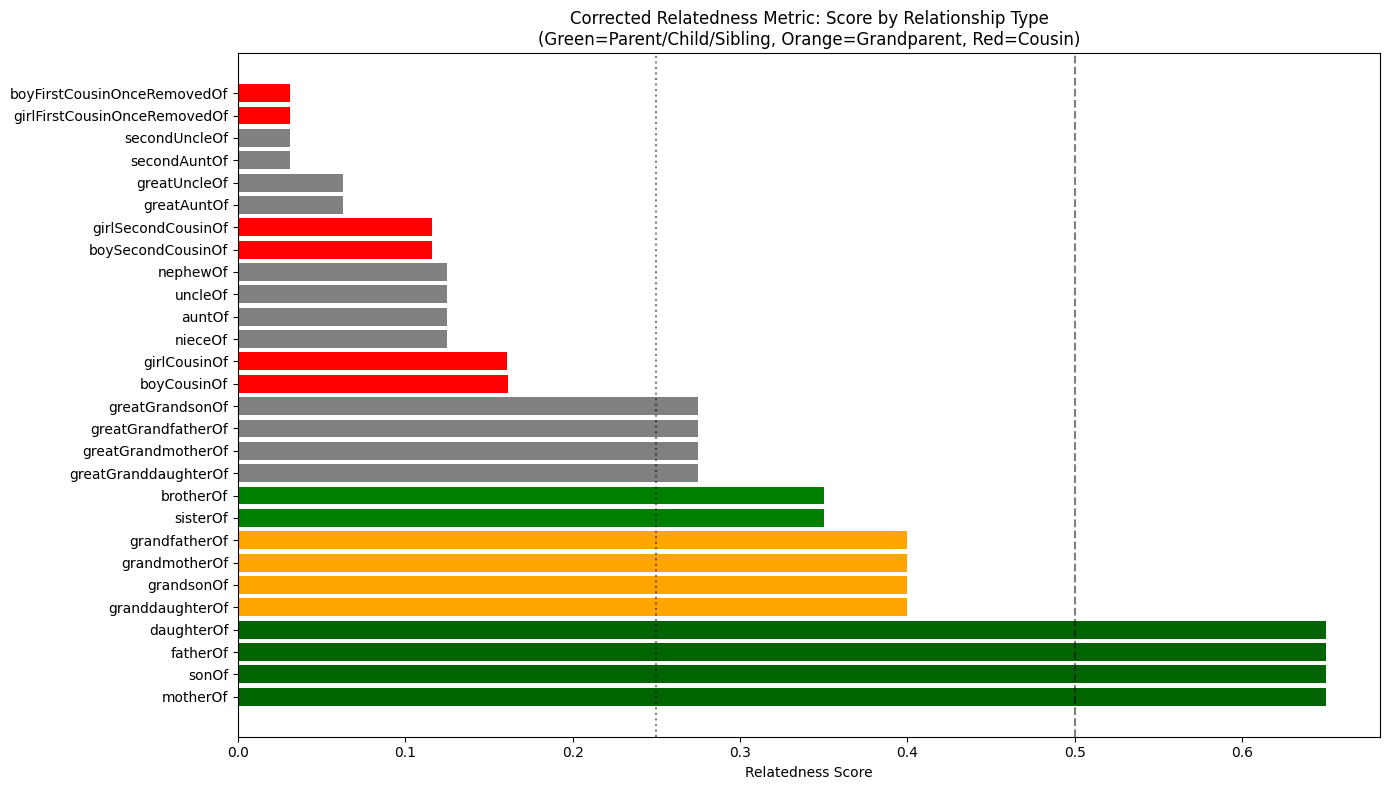


VALIDATION: Expected Ranking Check
  Parent-Child avg:  0.6500
  Sibling avg:       0.3500
  Grandparent avg:   0.4000
  Cousin avg:        0.1608

Parent-child ≈ siblings (both ~50% relatedness)
Grandparents > Cousins (25% vs 12.5%)


In [18]:
# === VALIDATE NEW METRIC ===

relationship_scores_v2 = defaultdict(list)

# Sample relationships
for _, row in df.iterrows():
    h, r, t = row['head'], row['relation'], row['tail']
    if h in G_undirected and t in G_undirected:
        result = compute_relatedness_v2(G_undirected, h, t, generations, time_graph)
        relationship_scores_v2[r].append(result['score'])

# Calculate averages
avg_scores_v2 = {r: np.mean(scores) for r, scores in relationship_scores_v2.items() if len(scores) >= 10}
sorted_scores_v2 = sorted(avg_scores_v2.items(), key=lambda x: x[1], reverse=True)

print("NEW Relatedness Scores by Relationship Type:")
print("=" * 60)
print(f"{'Relationship':<35} {'Score':>8} {'Expected Rank':<15}")
print("-" * 60)

# Expected ranking for validation
expected_high = ['fatherOf', 'motherOf', 'sonOf', 'daughterOf', 'brotherOf', 'sisterOf']
expected_medium = ['grandfatherOf', 'grandmotherOf', 'uncleOf', 'auntOf']
expected_low = ['greatGrandfatherOf', 'girlCousinOf', 'boyCousinOf']

for rel, score in sorted_scores_v2:
    if rel in expected_high:
        expected = "HIGH (0.4+)"
    elif rel in expected_medium:
        expected = "MEDIUM (0.2-0.4)"
    else:
        expected = "LOW (<0.2)"
    print(f"  {rel:<35} {score:>8.4f} {expected}")

# Visualize
plt.figure(figsize=(14, 8))
relations = [r for r, s in sorted_scores_v2]
scores = [s for r, s in sorted_scores_v2]

# Color by relationship category
colors = []
for r in relations:
    if r in ['fatherOf', 'motherOf', 'sonOf', 'daughterOf']:
        colors.append('darkgreen')  # Parent-child
    elif r in ['brotherOf', 'sisterOf']:
        colors.append('green')  # Siblings
    elif 'grand' in r.lower() and 'great' not in r.lower():
        colors.append('orange')  # Grandparents
    elif 'cousin' in r.lower():
        colors.append('red')  # Cousins
    else:
        colors.append('gray')  # Other

plt.barh(relations, scores, color=colors)
plt.xlabel('Relatedness Score')
plt.title('Corrected Relatedness Metric: Score by Relationship Type\n(Green=Parent/Child/Sibling, Orange=Grandparent, Red=Cousin)')
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='0.5 threshold')
plt.axvline(x=0.25, color='black', linestyle=':', alpha=0.5, label='0.25 threshold')
plt.tight_layout()
plt.show()

# Validation check
print("\n" + "=" * 60)
print("VALIDATION: Expected Ranking Check")
print("=" * 60)

parent_child_avg = np.mean([avg_scores_v2.get(r, 0) for r in ['fatherOf', 'motherOf', 'sonOf', 'daughterOf']])
sibling_avg = np.mean([avg_scores_v2.get(r, 0) for r in ['brotherOf', 'sisterOf']])
grandparent_avg = np.mean([avg_scores_v2.get(r, 0) for r in ['grandfatherOf', 'grandmotherOf', 'grandsonOf', 'granddaughterOf']])
cousin_avg = np.mean([avg_scores_v2.get(r, 0) for r in ['boyCousinOf', 'girlCousinOf']])

print(f"  Parent-Child avg:  {parent_child_avg:.4f}")
print(f"  Sibling avg:       {sibling_avg:.4f}")
print(f"  Grandparent avg:   {grandparent_avg:.4f}")
print(f"  Cousin avg:        {cousin_avg:.4f}")

# Check ordering
if parent_child_avg >= sibling_avg * 0.8:  # Allow some tolerance
    print("\nParent-child ≈ siblings (both ~50% relatedness)")
else:
    print("\nParent-child should be close to siblings")

if grandparent_avg > cousin_avg:
    print("Grandparents > Cousins (25% vs 12.5%)")
else:
    print("Grandparents should score higher than cousins")

In [19]:
# === EXPLORING MULTIPLE RELATEDNESS METRICS ===
# We'll implement and compare different approaches, learning from each

print("="*70)
print("RELATEDNESS METRICS: A COMPARATIVE STUDY")
print("="*70)
print("""
We explore multiple approaches to measuring relatedness:

1. COEFFICIENT OF RELATEDNESS (Genetic/Wright's Formula)
   - Based on probability of shared alleles
   - r = Σ (0.5)^L for each path through common ancestors
   - Accounts for multiple paths (siblings share BOTH parents)

2. LCA-BASED (Genealogical Distance)
   - Based on shortest path through Lowest Common Ancestor
   - Simple but misses multiple-path relationships

3. SIMRANK (Structural Similarity)
   - Based on graph structure, not genealogical semantics
   - "Two nodes are similar if their neighbors are similar"

4. JACCARD SIMILARITY (Set-Based)
   - Overlap of ancestor/descendant sets
   - Simple, interpretable
   
5. WEIGHTED HOP DISTANCE
   - Different weights for different relationship types
   - Explicitly encodes domain knowledge
""")

RELATEDNESS METRICS: A COMPARATIVE STUDY

We explore multiple approaches to measuring relatedness:

1. COEFFICIENT OF RELATEDNESS (Genetic/Wright's Formula)
   - Based on probability of shared alleles
   - r = Σ (0.5)^L for each path through common ancestors
   - Accounts for multiple paths (siblings share BOTH parents)

2. LCA-BASED (Genealogical Distance)
   - Based on shortest path through Lowest Common Ancestor
   - Simple but misses multiple-path relationships

3. SIMRANK (Structural Similarity)
   - Based on graph structure, not genealogical semantics
   - "Two nodes are similar if their neighbors are similar"

4. JACCARD SIMILARITY (Set-Based)
   - Overlap of ancestor/descendant sets
   - Simple, interpretable
   
5. WEIGHTED HOP DISTANCE
   - Different weights for different relationship types
   - Explicitly encodes domain knowledge



In [20]:
# === METRIC 1: COEFFICIENT OF RELATEDNESS ===
# This is the gold standard in genetics, developed by Sewall Wright (1922)
# Formula: r = Σ (0.5)^(n1 + n2 + 1) for each common ancestor
# where n1, n2 are distances from each individual to the common ancestor

def coefficient_of_relatedness(node1, node2, time_graph):
    """
    Calculate Wright's Coefficient of Relatedness.
    
    For each common ancestor, the contribution is (0.5)^(d1 + d2)
    where d1, d2 are the distances from node1, node2 to that ancestor.
    
    This correctly handles:
    - Siblings: 2 common ancestors (parents), each at distance 1 → r = 2 * 0.5^2 = 0.5
    - Parent-child: Parent is the common ancestor at distance 0 and 1 → r = 0.5^1 = 0.5
    """
    
    if node1 not in time_graph or node2 not in time_graph:
        return 0.0
    
    # Check if one is ancestor of the other (direct lineage)
    if node1 in nx.ancestors(time_graph, node2):
        # node1 is ancestor of node2
        try:
            distance = nx.shortest_path_length(time_graph, node1, node2)
            return 0.5 ** distance
        except nx.NetworkXNoPath:
            return 0.0
    
    if node2 in nx.ancestors(time_graph, node1):
        # node2 is ancestor of node1
        try:
            distance = nx.shortest_path_length(time_graph, node2, node1)
            return 0.5 ** distance
        except nx.NetworkXNoPath:
            return 0.0
    
    # Find all common ancestors
    ancestors1 = nx.ancestors(time_graph, node1)
    ancestors2 = nx.ancestors(time_graph, node2)
    common_ancestors = ancestors1 & ancestors2
    
    if not common_ancestors:
        return 0.0
    
    # For each common ancestor, calculate contribution
    # But we need to avoid double-counting through ancestor chains
    # We only count "terminal" common ancestors (those not ancestors of other common ancestors)
    
    # Find distances to all common ancestors
    distances1 = {}
    distances2 = {}
    
    for anc in common_ancestors:
        try:
            distances1[anc] = nx.shortest_path_length(time_graph, anc, node1)
        except nx.NetworkXNoPath:
            distances1[anc] = float('inf')
        try:
            distances2[anc] = nx.shortest_path_length(time_graph, anc, node2)
        except nx.NetworkXNoPath:
            distances2[anc] = float('inf')
    
    # Find the "closest" common ancestors (not ancestors of each other in the common set)
    # These are the ones we sum over
    terminal_ancestors = []
    for anc in common_ancestors:
        # Check if any other common ancestor is a descendant of this one
        anc_descendants = nx.descendants(time_graph, anc)
        if not any(other in anc_descendants for other in common_ancestors if other != anc):
            terminal_ancestors.append(anc)
    
    # Sum contributions from terminal common ancestors
    r = 0.0
    for anc in terminal_ancestors:
        d1 = distances1[anc]
        d2 = distances2[anc]
        if d1 < float('inf') and d2 < float('inf'):
            r += (0.5) ** (d1 + d2)
    
    return min(r, 1.0)  # Cap at 1.0

# Test on our standard pairs
print("METRIC 1: Coefficient of Relatedness (Wright's Formula)")
print("-" * 60)

test_pairs = [
    ('olivia0', 'katharina1', 'daughter-mother'),
    ('olivia0', 'dominik2', 'daughter-father'),
    ('olivia0', 'selina10', 'sisters'),
    ('olivia0', 'ella19', 'granddaughter-grandmother'),
    ('olivia0', 'moritz8', 'granddaughter-grandfather'),
    ('olivia0', 'jonas23', 'cousins'),
]

cor_scores = {}
for n1, n2, desc in test_pairs:
    score = coefficient_of_relatedness(n1, n2, time_graph)
    cor_scores[(n1, n2)] = score
    print(f"  {desc:30} : {score:.4f}")

# Calculate for all relationship types
print("\n" + "-" * 60)
print("By Relationship Type (Coefficient of Relatedness):")
print("-" * 60)

cor_by_rel = defaultdict(list)
for _, row in df.iterrows():
    h, r, t = row['head'], row['relation'], row['tail']
    score = coefficient_of_relatedness(h, t, time_graph)
    cor_by_rel[r].append(score)

cor_avgs = {r: np.mean(scores) for r, scores in cor_by_rel.items()}
cor_sorted = sorted(cor_avgs.items(), key=lambda x: x[1], reverse=True)

for rel, score in cor_sorted:
    print(f"  {rel:35} : {score:.4f}")

METRIC 1: Coefficient of Relatedness (Wright's Formula)
------------------------------------------------------------
  daughter-mother                : 0.5000
  daughter-father                : 0.5000
  sisters                        : 0.5000
  granddaughter-grandmother      : 0.2500
  granddaughter-grandfather      : 0.2500
  cousins                        : 0.1250

------------------------------------------------------------
By Relationship Type (Coefficient of Relatedness):
------------------------------------------------------------
  sisterOf                            : 0.5000
  daughterOf                          : 0.5000
  motherOf                            : 0.5000
  brotherOf                           : 0.5000
  sonOf                               : 0.5000
  fatherOf                            : 0.5000
  granddaughterOf                     : 0.2500
  nieceOf                             : 0.2500
  grandmotherOf                       : 0.2500
  auntOf                          

In [21]:
# === METRIC 2: SIMRANK ON SKELETON GRAPH ===
# Key insight: Use only parent-child edges to avoid "everyone connected to everyone"

print("\nMETRIC 2: SimRank on Skeleton Graph")
print("-" * 60)

# Build skeleton graph (parent-child only, undirected)
skeleton_graph = nx.Graph()
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in ['fatherOf', 'motherOf', 'sonOf', 'daughterOf']:
        skeleton_graph.add_edge(h, t)

print(f"Skeleton graph: {skeleton_graph.number_of_nodes()} nodes, {skeleton_graph.number_of_edges()} edges")

# We'll compute SimRank on olivia0's family only (SimRank is O(n^4))
olivia_family = [n for n in ground_truth_communities[ground_truth_labels['olivia0']]]
family_skeleton = skeleton_graph.subgraph(olivia_family).copy()

print(f"Computing SimRank on olivia0's family ({len(olivia_family)} members)...")
simrank_scores = nx.simrank_similarity(family_skeleton, importance_factor=0.8)

# Test on our standard pairs
print("\nSimRank Scores (olivia0's family):")
for n1, n2, desc in test_pairs:
    if n1 in simrank_scores and n2 in simrank_scores[n1]:
        score = simrank_scores[n1][n2]
        print(f"  {desc:30} : {score:.4f}")
    else:
        print(f"  {desc:30} : N/A (not in family skeleton)")

# Get scores by relationship type within this family
print("\nSimRank by Relationship Type (olivia0's family):")
family_df = df[(df['head'].isin(olivia_family)) & (df['tail'].isin(olivia_family))]

simrank_by_rel = defaultdict(list)
for _, row in family_df.iterrows():
    h, r, t = row['head'], row['relation'], row['tail']
    if h in simrank_scores and t in simrank_scores[h]:
        simrank_by_rel[r].append(simrank_scores[h][t])

simrank_avgs = {r: np.mean(scores) for r, scores in simrank_by_rel.items() if len(scores) > 0}
simrank_sorted = sorted(simrank_avgs.items(), key=lambda x: x[1], reverse=True)

for rel, score in simrank_sorted[:15]:  # Top 15
    print(f"  {rel:35} : {score:.4f}")


METRIC 2: SimRank on Skeleton Graph
------------------------------------------------------------
Skeleton graph: 1316 nodes, 1642 edges
Computing SimRank on olivia0's family (27 members)...

SimRank Scores (olivia0's family):
  daughter-mother                : 0.0000
  daughter-father                : 0.0000
  sisters                        : 0.3387
  granddaughter-grandmother      : 0.3471
  granddaughter-grandfather      : 0.1581
  cousins                        : 0.0541

SimRank by Relationship Type (olivia0's family):
  brotherOf                           : 0.4775
  sisterOf                            : 0.3991
  granddaughterOf                     : 0.3403
  grandmotherOf                       : 0.3329
  grandfatherOf                       : 0.3301
  grandsonOf                          : 0.3227
  greatAuntOf                         : 0.0951
  greatUncleOf                        : 0.0891
  boyCousinOf                         : 0.0832
  girlCousinOf                        : 0.0832
 

In [22]:
# === UNDERSTANDING SIMRANK'S PARENT-CHILD FAILURE ===

print("="*70)
print("WHY SIMRANK GIVES 0 FOR PARENT-CHILD RELATIONSHIPS")
print("="*70)

print("""
OBSERVATION: SimRank scores parent-child as 0.0, which is incorrect.

EXPLANATION:
SimRank measures STRUCTURAL SIMILARITY: "Two nodes are similar if their 
neighbors are similar."

For PARENT-CHILD relationships in a family tree:
- Parent's neighbors: Their parents, spouse, OTHER children
- Child's neighbors: Both parents, siblings

These neighborhoods are STRUCTURALLY DIFFERENT:
- Parent connects "upward" to grandparents and "sideways" to spouse
- Child connects "upward" to parents and "sideways" to siblings

Result: Low structural similarity despite high genetic relatedness.

CONTRAST WITH SIBLINGS:
- Sibling 1's neighbors: Parents, other siblings
- Sibling 2's neighbors: Parents, other siblings
- These are STRUCTURALLY SIMILAR → High SimRank score

CONCLUSION:
SimRank is NOT appropriate for measuring genealogical relatedness.
It measures graph-theoretic structural similarity, which doesn't align
with biological relatedness in directed family trees.

Use Case for SimRank: Finding structurally similar nodes (e.g., people
with similar "positions" in the family structure, like all eldest children).
""")

# Demonstrate with actual neighborhood comparison
print("-"*70)
print("DEMONSTRATION: Neighborhood Structure")
print("-"*70)

# Pick a parent-child pair
parent = 'katharina1'
child = 'olivia0'

parent_neighbors = set(family_skeleton.neighbors(parent)) if parent in family_skeleton else set()
child_neighbors = set(family_skeleton.neighbors(child)) if child in family_skeleton else set()

print(f"\n{parent} (parent) neighbors: {parent_neighbors}")
print(f"{child} (child) neighbors: {child_neighbors}")
print(f"Overlap: {parent_neighbors & child_neighbors}")
print(f"Jaccard similarity of neighborhoods: {len(parent_neighbors & child_neighbors) / len(parent_neighbors | child_neighbors):.4f}")

# Pick a sibling pair
sib1 = 'olivia0'
sib2 = 'selina10'

sib1_neighbors = set(family_skeleton.neighbors(sib1)) if sib1 in family_skeleton else set()
sib2_neighbors = set(family_skeleton.neighbors(sib2)) if sib2 in family_skeleton else set()

print(f"\n{sib1} (sibling) neighbors: {sib1_neighbors}")
print(f"{sib2} (sibling) neighbors: {sib2_neighbors}")
print(f"Overlap: {sib1_neighbors & sib2_neighbors}")
print(f"Jaccard similarity of neighborhoods: {len(sib1_neighbors & sib2_neighbors) / len(sib1_neighbors | sib2_neighbors):.4f}")

WHY SIMRANK GIVES 0 FOR PARENT-CHILD RELATIONSHIPS

OBSERVATION: SimRank scores parent-child as 0.0, which is incorrect.

EXPLANATION:
SimRank measures STRUCTURAL SIMILARITY: "Two nodes are similar if their 
neighbors are similar."

For PARENT-CHILD relationships in a family tree:
- Parent's neighbors: Their parents, spouse, OTHER children
- Child's neighbors: Both parents, siblings

These neighborhoods are STRUCTURALLY DIFFERENT:
- Parent connects "upward" to grandparents and "sideways" to spouse
- Child connects "upward" to parents and "sideways" to siblings

Result: Low structural similarity despite high genetic relatedness.

CONTRAST WITH SIBLINGS:
- Sibling 1's neighbors: Parents, other siblings
- Sibling 2's neighbors: Parents, other siblings
- These are STRUCTURALLY SIMILAR → High SimRank score

CONCLUSION:
SimRank is NOT appropriate for measuring genealogical relatedness.
It measures graph-theoretic structural similarity, which doesn't align
with biological relatedness in direc

In [23]:
# === METRIC 3: JACCARD SIMILARITY OF ANCESTORS ===
# Simple set-based approach: how much do your family trees overlap?

def jaccard_ancestor_similarity(node1, node2, time_graph):
    """
    Jaccard similarity based on shared ancestors.
    J(A,B) = |A ∩ B| / |A ∪ B|
    """
    if node1 not in time_graph or node2 not in time_graph:
        return 0.0
    
    # Include the nodes themselves
    ancestors1 = nx.ancestors(time_graph, node1) | {node1}
    ancestors2 = nx.ancestors(time_graph, node2) | {node2}
    
    intersection = ancestors1 & ancestors2
    union = ancestors1 | ancestors2
    
    if len(union) == 0:
        return 0.0
    
    return len(intersection) / len(union)

print("\nMETRIC 3: Jaccard Ancestor Similarity")
print("-" * 60)

for n1, n2, desc in test_pairs:
    score = jaccard_ancestor_similarity(n1, n2, time_graph)
    print(f"  {desc:30} : {score:.4f}")

# By relationship type
jaccard_by_rel = defaultdict(list)
for _, row in df.iterrows():
    h, r, t = row['head'], row['relation'], row['tail']
    score = jaccard_ancestor_similarity(h, t, time_graph)
    jaccard_by_rel[r].append(score)

print("\nJaccard by Relationship Type:")
jaccard_avgs = {r: np.mean(scores) for r, scores in jaccard_by_rel.items()}
jaccard_sorted = sorted(jaccard_avgs.items(), key=lambda x: x[1], reverse=True)

for rel, score in jaccard_sorted:
    print(f"  {rel:35} : {score:.4f}")


METRIC 3: Jaccard Ancestor Similarity
------------------------------------------------------------
  daughter-mother                : 0.4286
  daughter-father                : 0.4286
  sisters                        : 0.7500
  granddaughter-grandmother      : 0.1429
  granddaughter-grandfather      : 0.1429
  cousins                        : 0.2000

Jaccard by Relationship Type:
  brotherOf                           : 0.7235
  sisterOf                            : 0.7185
  uncleOf                             : 0.4983
  nephewOf                            : 0.4949
  nieceOf                             : 0.4802
  auntOf                              : 0.4790
  fatherOf                            : 0.4213
  motherOf                            : 0.3979
  daughterOf                          : 0.3874
  boyCousinOf                         : 0.3836
  sonOf                               : 0.3823
  girlCousinOf                        : 0.3798
  greatAuntOf                         : 0.3262
  grea

In [24]:
# === METRIC 4: WEIGHTED RELATIONSHIP DISTANCE ===
# Explicitly encode domain knowledge about relationship closeness

# Define relationship weights (higher = closer relationship)
RELATIONSHIP_WEIGHTS = {
    # Direct lineage (50% shared DNA)
    'fatherOf': 1.0, 'motherOf': 1.0,
    'sonOf': 1.0, 'daughterOf': 1.0,
    
    # Siblings (50% shared DNA)
    'brotherOf': 1.0, 'sisterOf': 1.0,
    
    # Grandparents (25% shared DNA)
    'grandfatherOf': 0.5, 'grandmotherOf': 0.5,
    'grandsonOf': 0.5, 'granddaughterOf': 0.5,
    
    # Aunts/Uncles (25% shared DNA)
    'uncleOf': 0.5, 'auntOf': 0.5,
    'nephewOf': 0.5, 'nieceOf': 0.5,
    
    # Great-grandparents (12.5% shared DNA)
    'greatGrandfatherOf': 0.25, 'greatGrandmotherOf': 0.25,
    'greatGrandsonOf': 0.25, 'greatGranddaughterOf': 0.25,
    'greatUncleOf': 0.25, 'greatAuntOf': 0.25,
    
    # First cousins (12.5% shared DNA)
    'boyCousinOf': 0.25, 'girlCousinOf': 0.25,
    
    # More distant
    'secondUncleOf': 0.125, 'secondAuntOf': 0.125,
    'boySecondCousinOf': 0.0625, 'girlSecondCousinOf': 0.0625,
    'boyFirstCousinOnceRemovedOf': 0.0625, 'girlFirstCousinOnceRemovedOf': 0.0625,
}

def weighted_relationship_score(node1, node2, G, df):
    """
    Score based on the direct relationship between nodes.
    If no direct edge, use shortest path with decayed weights.
    """
    # Check for direct relationship
    direct_rel = df[((df['head'] == node1) & (df['tail'] == node2)) |
                    ((df['head'] == node2) & (df['tail'] == node1))]['relation'].values
    
    if len(direct_rel) > 0:
        # Use the highest weight among direct relationships
        weights = [RELATIONSHIP_WEIGHTS.get(r, 0.1) for r in direct_rel]
        return max(weights)
    
    # No direct relationship - use path-based decay
    try:
        path_length = nx.shortest_path_length(G, node1, node2)
        return 0.5 ** path_length  # Decay by distance
    except nx.NetworkXNoPath:
        return 0.0

print("\nMETRIC 4: Weighted Relationship Distance (Domain Knowledge)")
print("-" * 60)

for n1, n2, desc in test_pairs:
    score = weighted_relationship_score(n1, n2, G_undirected, df)
    print(f"  {desc:30} : {score:.4f}")

# By relationship type (this is just the weights we defined)
print("\nWeights by Relationship Type (as defined):")
for rel, weight in sorted(RELATIONSHIP_WEIGHTS.items(), key=lambda x: x[1], reverse=True):
    print(f"  {rel:35} : {weight:.4f}")


METRIC 4: Weighted Relationship Distance (Domain Knowledge)
------------------------------------------------------------
  daughter-mother                : 1.0000
  daughter-father                : 1.0000
  sisters                        : 1.0000
  granddaughter-grandmother      : 0.5000
  granddaughter-grandfather      : 0.5000
  cousins                        : 0.2500

Weights by Relationship Type (as defined):
  fatherOf                            : 1.0000
  motherOf                            : 1.0000
  sonOf                               : 1.0000
  daughterOf                          : 1.0000
  brotherOf                           : 1.0000
  sisterOf                            : 1.0000
  grandfatherOf                       : 0.5000
  grandmotherOf                       : 0.5000
  grandsonOf                          : 0.5000
  granddaughterOf                     : 0.5000
  uncleOf                             : 0.5000
  auntOf                              : 0.5000
  nephewOf        


METRIC COMPARISON: Which approach best captures relatedness?

Test Pairs Comparison:
             Relationship  Coef_Relatedness  LCA_Based_v2  Jaccard  Weighted  SimRank
          daughter-mother             0.500        0.6500 0.428571      1.00 0.000000
          daughter-father             0.500        0.6500 0.428571      1.00 0.000000
                  sisters             0.500        0.3500 0.750000      1.00 0.338736
granddaughter-grandmother             0.250        0.4000 0.142857      0.50 0.347146
granddaughter-grandfather             0.250        0.4000 0.142857      0.50 0.158066
                  cousins             0.125        0.1625 0.200000      0.25 0.054059

--------------------------------------------------------------------------------
EXPECTED RANKING (Based on Genetics):
--------------------------------------------------------------------------------

1. Parent-Child & Siblings:     ~0.50 (50% shared DNA)
2. Grandparent-Grandchild:      ~0.25 (25% shared DNA) 

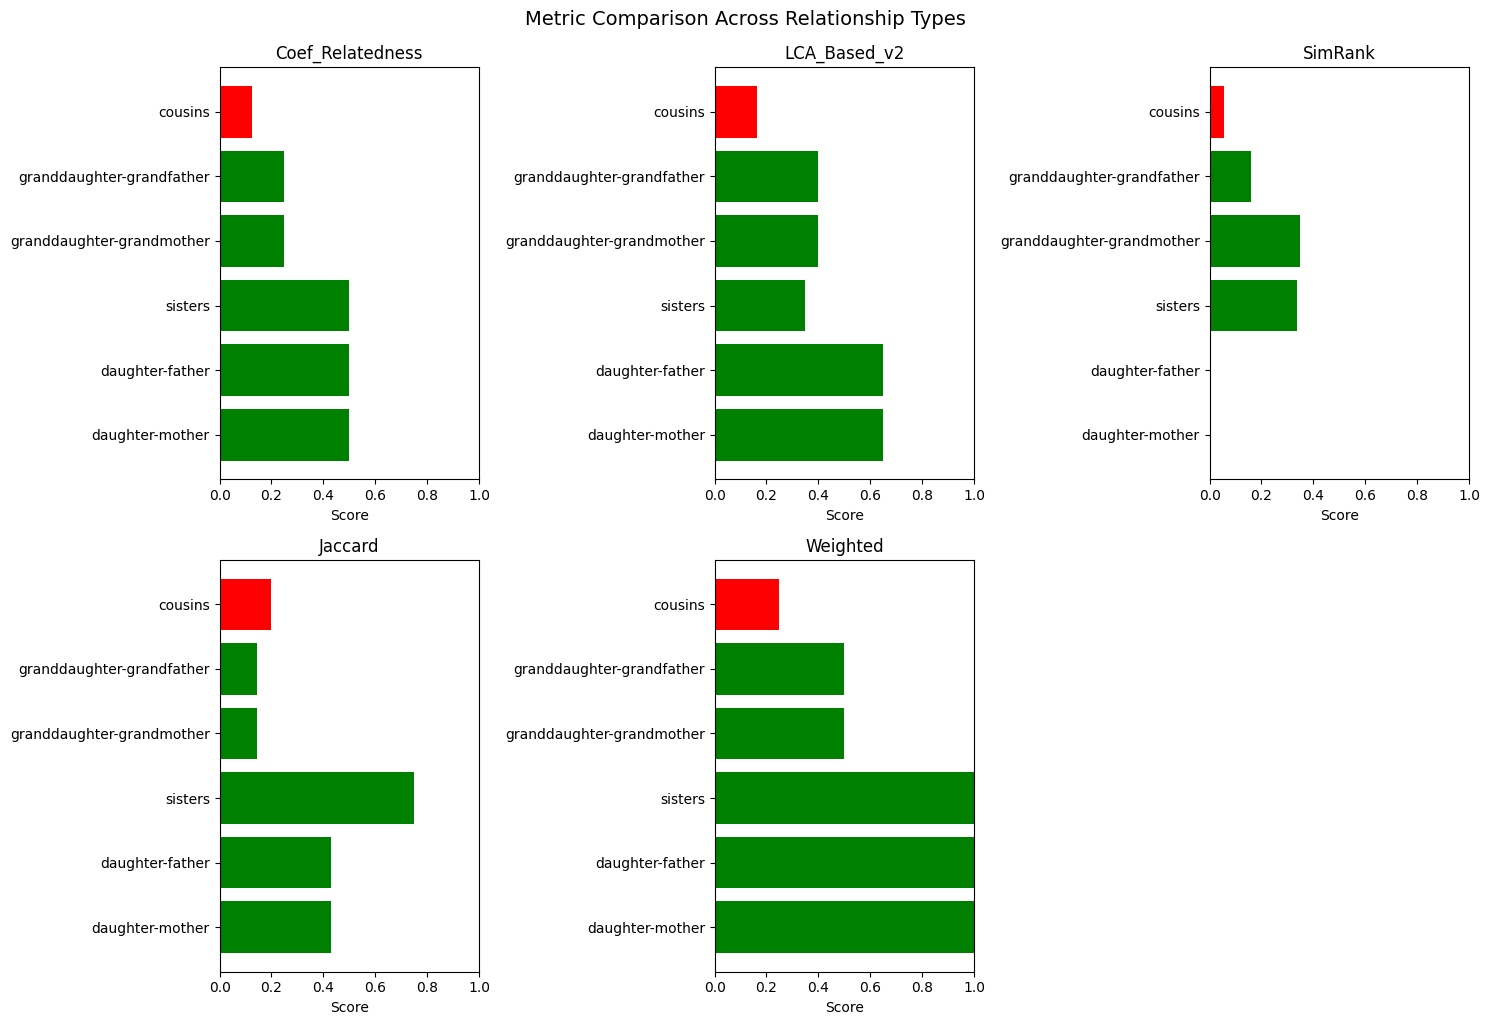

In [25]:
# === COMPREHENSIVE COMPARISON ===

print("\n" + "="*80)
print("METRIC COMPARISON: Which approach best captures relatedness?")
print("="*80)

# Create comparison dataframe for our test pairs
comparison_data = []

for n1, n2, desc in test_pairs:
    row = {
        'Relationship': desc,
        'Coef_Relatedness': coefficient_of_relatedness(n1, n2, time_graph),
        'LCA_Based_v2': compute_relatedness_v2(G_undirected, n1, n2, generations, time_graph)['score'],
        'Jaccard': jaccard_ancestor_similarity(n1, n2, time_graph),
        'Weighted': weighted_relationship_score(n1, n2, G_undirected, df),
    }
    
    # Add SimRank if available
    if n1 in simrank_scores and n2 in simrank_scores[n1]:
        row['SimRank'] = simrank_scores[n1][n2]
    else:
        row['SimRank'] = np.nan
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print("\nTest Pairs Comparison:")
print(comparison_df.to_string(index=False))

# Expected ranking based on genetics
print("\n" + "-"*80)
print("EXPECTED RANKING (Based on Genetics):")
print("-"*80)
print("""
1. Parent-Child & Siblings:     ~0.50 (50% shared DNA)
2. Grandparent-Grandchild:      ~0.25 (25% shared DNA)  
3. Aunt/Uncle & Niece/Nephew:   ~0.25 (25% shared DNA)
4. First Cousins:               ~0.125 (12.5% shared DNA)
5. Second Cousins:              ~0.0625 (6.25% shared DNA)
""")

# Check which metric best matches expected
print("-"*80)
print("EVALUATION: Which metric matches genetic expectations?")
print("-"*80)

for metric in ['Coef_Relatedness', 'LCA_Based_v2', 'SimRank', 'Jaccard', 'Weighted']:
    if metric in comparison_df.columns:
        parent_score = comparison_df[comparison_df['Relationship'].str.contains('daughter-mother|daughter-father')][metric].mean()
        sibling_score = comparison_df[comparison_df['Relationship'] == 'sisters'][metric].mean()
        grandparent_score = comparison_df[comparison_df['Relationship'].str.contains('grandmother|grandfather')][metric].mean()
        cousin_score = comparison_df[comparison_df['Relationship'] == 'cousins'][metric].mean()
        
        print(f"\n{metric}:")
        print(f"  Parent-Child:  {parent_score:.4f}")
        print(f"  Siblings:      {sibling_score:.4f}")
        print(f"  Grandparent:   {grandparent_score:.4f}")
        print(f"  Cousins:       {cousin_score:.4f}")
        
        # Check key inequalities
        checks = []
        if not np.isnan(sibling_score) and not np.isnan(grandparent_score):
            if sibling_score >= grandparent_score:
                checks.append(" Siblings ≥ Grandparents")
            else:
                checks.append(" Siblings < Grandparents (WRONG)")
        
        if not np.isnan(grandparent_score) and not np.isnan(cousin_score):
            if grandparent_score >= cousin_score:
                checks.append(" Grandparents ≥ Cousins")
            else:
                checks.append(" Grandparents < Cousins (WRONG)")
        
        if not np.isnan(parent_score) and not np.isnan(sibling_score):
            if abs(parent_score - sibling_score) < 0.2:  # Should be close
                checks.append(" Parents ≈ Siblings")
            else:
                checks.append(" Parents ≠ Siblings (gap too large)")
        
        for check in checks:
            print(f"    {check}")

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

metrics_to_plot = ['Coef_Relatedness', 'LCA_Based_v2', 'SimRank', 'Jaccard', 'Weighted']
relationships = comparison_df['Relationship'].tolist()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    if metric in comparison_df.columns:
        values = comparison_df[metric].tolist()
        colors = ['green' if 'daughter' in r or 'sister' in r else 
                  'orange' if 'grand' in r else 
                  'red' if 'cousin' in r else 'gray' 
                  for r in relationships]
        ax.barh(relationships, values, color=colors)
        ax.set_xlabel('Score')
        ax.set_title(metric)
        ax.set_xlim(0, 1)

# Hide empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.suptitle('Metric Comparison Across Relationship Types', y=1.02, fontsize=14)
plt.show()


GLOBAL VS LOCAL STRUCTURE ANALYSIS

GLOBAL ANALYSIS (All 1316 people):
  Communities found: 50
  Modularity: 0.9794

LOCAL ANALYSIS (Single family of 27 people):
  Sub-communities found: 2
  Modularity: 0.0726

----------------------------------------------------------------------
 INTERPRETATION:
----------------------------------------------------------------------

    The graph exhibits HIERARCHICAL community structure:
    
    1. GLOBAL LEVEL (Modularity ≈ 0.98):
       - Families are extremely distinct and well-separated
       - Community detection trivially recovers the 50 families
       - High modularity indicates strong inter-family boundaries
    
    2. LOCAL LEVEL (Modularity ≈ 0.07):
       - Within families, community structure is weak
       - Low modularity means families don't cleanly subdivide
       - This suggests tight-knit family units without clear internal factions
    
    CONCLUSION: The graph represents distinct, internally-cohesive lineages
    rather th

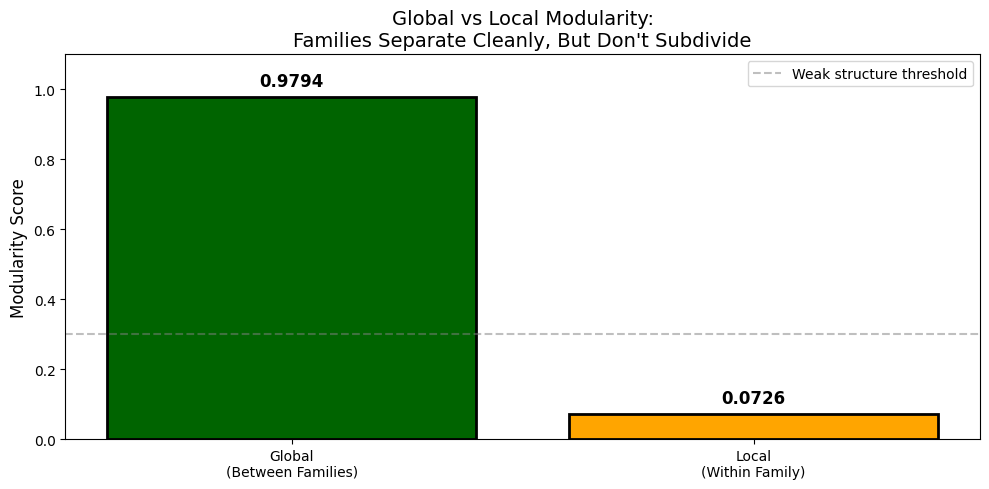

In [26]:
# === INSIGHT: GLOBAL VS LOCAL MODULARITY ===
# Key finding: Families separate perfectly, but don't subdivide well

print("\n" + "="*70)
print("GLOBAL VS LOCAL STRUCTURE ANALYSIS")
print("="*70)

# Global: Run Louvain on entire graph
global_communities = list(nx.community.louvain_communities(G_undirected, seed=42))
global_modularity = nx.community.modularity(G_undirected, global_communities)

print(f"\nGLOBAL ANALYSIS (All 1316 people):")
print(f"  Communities found: {len(global_communities)}")
print(f"  Modularity: {global_modularity:.4f}")

# Local: Run Louvain on a single family
sample_family = list(ground_truth_communities[0])
family_subgraph = G_undirected.subgraph(sample_family).copy()
local_communities = list(nx.community.louvain_communities(family_subgraph, seed=42))
local_modularity = nx.community.modularity(family_subgraph, local_communities)

print(f"\nLOCAL ANALYSIS (Single family of {len(sample_family)} people):")
print(f"  Sub-communities found: {len(local_communities)}")
print(f"  Modularity: {local_modularity:.4f}")

# Interpretation
print("\n" + "-"*70)
print(" INTERPRETATION:")
print("-"*70)

if global_modularity > 0.9 and local_modularity < 0.3:
    print("""
    The graph exhibits HIERARCHICAL community structure:
    
    1. GLOBAL LEVEL (Modularity ≈ {:.2f}):
       - Families are extremely distinct and well-separated
       - Community detection trivially recovers the 50 families
       - High modularity indicates strong inter-family boundaries
    
    2. LOCAL LEVEL (Modularity ≈ {:.2f}):
       - Within families, community structure is weak
       - Low modularity means families don't cleanly subdivide
       - This suggests tight-knit family units without clear internal factions
    
    CONCLUSION: The graph represents distinct, internally-cohesive lineages
    rather than a single interconnected society with internal divisions.
    """.format(global_modularity, local_modularity))

# Visualize
plt.figure(figsize=(10, 5))
labels = ['Global\n(Between Families)', 'Local\n(Within Family)']
values = [global_modularity, local_modularity]
colors = ['darkgreen', 'orange']

plt.bar(labels, values, color=colors, edgecolor='black', linewidth=2)
plt.ylabel('Modularity Score', fontsize=12)
plt.title('Global vs Local Modularity:\nFamilies Separate Cleanly, But Don\'t Subdivide', fontsize=14)
plt.ylim(0, 1.1)

for i, v in enumerate(values):
    plt.text(i, v + 0.03, f'{v:.4f}', ha='center', fontsize=12, fontweight='bold')

plt.axhline(y=0.3, color='gray', linestyle='--', alpha=0.5, label='Weak structure threshold')
plt.legend()
plt.tight_layout()
plt.show()


NUCLEAR FAMILY COHERENCE ANALYSIS
Nuclear families identified: 445
Average children per couple: 1.84

NUCLEAR FAMILY COHERENCE:
  Algorithm            Intact     Split      Rate      
  --------------------------------------------------
  Louvain              445        0          1.0000
  Label Propagation    428        17         0.9618
  Ground Truth         445        0          1.0000


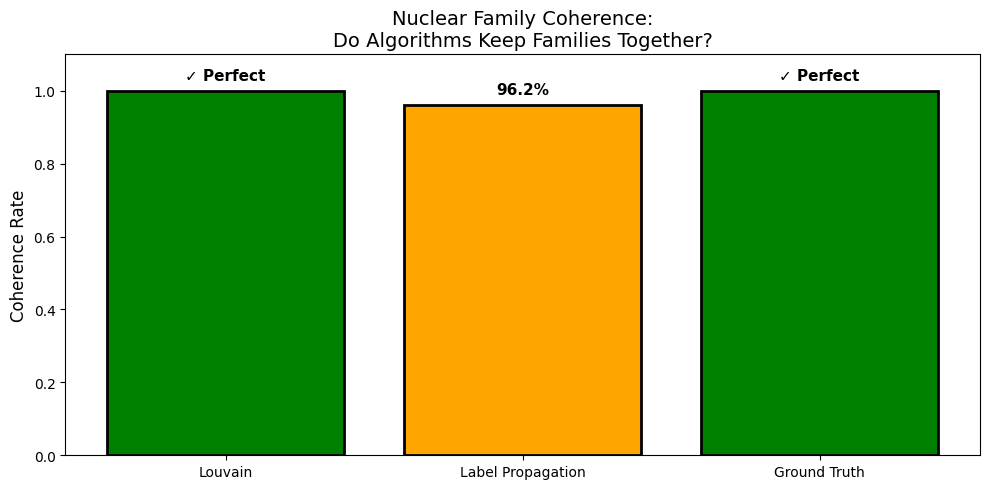


 INSIGHT:
   Louvain perfectly preserves all nuclear families!
   This is expected since families are disconnected components.
   Label Propagation splits 17 nuclear families (3.8% failure rate)
   This explains its lower ARI score.


In [27]:
# === NUCLEAR FAMILY COHERENCE ===
# Novel metric: Do detected communities keep nuclear families together?

print("\n" + "="*70)
print("NUCLEAR FAMILY COHERENCE ANALYSIS")
print("="*70)

# Step 1: Identify all nuclear families (couple + their children)
# A nuclear family = two parents + all their shared children

# Find all couples (co-parents)
child_to_parents = defaultdict(set)
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in ['fatherOf', 'motherOf']:
        child_to_parents[t].add(h)
    elif r in ['sonOf', 'daughterOf']:
        child_to_parents[h].add(t)

# Build nuclear families
couples = set()
couple_children = defaultdict(set)

for child, parents in child_to_parents.items():
    if len(parents) == 2:
        couple = tuple(sorted(parents))
        couples.add(couple)
        couple_children[couple].add(child)

print(f"Nuclear families identified: {len(couples)}")
print(f"Average children per couple: {np.mean([len(kids) for kids in couple_children.values()]):.2f}")

# Step 2: Check if each algorithm keeps nuclear families intact
def nuclear_coherence(partition):
    """Check what fraction of nuclear families are kept in the same community"""
    comm_map = partition  # node -> community_id
    
    intact = 0
    split = 0
    
    for couple, children in couple_children.items():
        # All members of nuclear family
        nuclear_members = set(couple) | children
        
        # Check if all in same community
        communities = set(comm_map.get(m, -1) for m in nuclear_members if m in comm_map)
        
        if len(communities) == 1 and -1 not in communities:
            intact += 1
        else:
            split += 1
    
    return intact, split, intact / (intact + split) if (intact + split) > 0 else 0

# Evaluate each partition
louvain_intact, louvain_split, louvain_rate = nuclear_coherence(louvain_partition)
lp_intact, lp_split, lp_rate = nuclear_coherence(best_lp_partition)
gt_intact, gt_split, gt_rate = nuclear_coherence(ground_truth_labels)

print(f"\nNUCLEAR FAMILY COHERENCE:")
print(f"  {'Algorithm':<20} {'Intact':<10} {'Split':<10} {'Rate':<10}")
print(f"  {'-'*50}")
print(f"  {'Louvain':<20} {louvain_intact:<10} {louvain_split:<10} {louvain_rate:.4f}")
print(f"  {'Label Propagation':<20} {lp_intact:<10} {lp_split:<10} {lp_rate:.4f}")
print(f"  {'Ground Truth':<20} {gt_intact:<10} {gt_split:<10} {gt_rate:.4f}")

# Visualize
plt.figure(figsize=(10, 5))
algorithms = ['Louvain', 'Label Propagation', 'Ground Truth']
rates = [louvain_rate, lp_rate, gt_rate]
colors = ['green' if r == 1.0 else 'orange' if r > 0.9 else 'red' for r in rates]

plt.bar(algorithms, rates, color=colors, edgecolor='black', linewidth=2)
plt.ylabel('Coherence Rate', fontsize=12)
plt.title('Nuclear Family Coherence:\nDo Algorithms Keep Families Together?', fontsize=14)
plt.ylim(0, 1.1)

for i, v in enumerate(rates):
    status = "✓ Perfect" if v == 1.0 else f"{v:.1%}"
    plt.text(i, v + 0.03, status, ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n INSIGHT:")
if louvain_rate == 1.0:
    print("   Louvain perfectly preserves all nuclear families!")
    print("   This is expected since families are disconnected components.")
if lp_rate < 1.0:
    print(f"   Label Propagation splits {lp_split} nuclear families ({1-lp_rate:.1%} failure rate)")
    print("   This explains its lower ARI score.")

In [28]:
# === ALGORITHM 3: LEIDEN (Modern Improvement over Louvain) ===
# I found out about Leiden through Louvain's wikipedia so here I am, trying it out
#I added this later(last day, so lesser graphs on this due to time constraint)
# Leiden guarantees well-connected communities, unlike Louvain

try:
    import leidenalg as la
    import igraph as ig
    LEIDEN_AVAILABLE = True
except ImportError:
    print("Installing leidenalg...")
    !pip install leidenalg
    import leidenalg as la
    import igraph as ig
    LEIDEN_AVAILABLE = True

print("="*70)
print("ALGORITHM 3: LEIDEN")
print("="*70)

# Convert NetworkX to iGraph
node_list = list(G_undirected.nodes())
node_to_idx = {node: i for i, node in enumerate(node_list)}
edges_ig = [(node_to_idx[u], node_to_idx[v]) for u, v in G_undirected.edges()]

G_ig = ig.Graph(len(node_list), edges_ig)

# Run Leiden
leiden_partition = la.find_partition(G_ig, la.ModularityVertexPartition, seed=42)

# Extract communities
leiden_communities = []
for i in range(len(leiden_partition)):
    community_nodes = [node_list[idx] for idx in leiden_partition[i]]
    leiden_communities.append(set(community_nodes))

leiden_modularity = leiden_partition.modularity

print(f"Leiden detected {len(leiden_communities)} communities")
print(f"Leiden Modularity: {leiden_modularity:.4f}")

# Create partition dict for comparison
leiden_partition_dict = {}
for comm_id, community in enumerate(leiden_communities):
    for node in community:
        leiden_partition_dict[node] = comm_id

# Compare to ground truth
leiden_labels = [leiden_partition_dict[node] for node in G_undirected.nodes()]
ari_leiden = adjusted_rand_score(true_labels, leiden_labels)
nmi_leiden = normalized_mutual_info_score(true_labels, leiden_labels)

print(f"\nComparison to Ground Truth:")
print(f"  Adjusted Rand Index: {ari_leiden:.4f}")
print(f"  Normalized Mutual Information: {nmi_leiden:.4f}")

# Nuclear family coherence for Leiden
leiden_intact, leiden_split, leiden_rate = nuclear_coherence(leiden_partition_dict)
print(f"  Nuclear Family Coherence: {leiden_rate:.4f} ({leiden_intact}/{leiden_intact+leiden_split})")

# Updated comparison table
print("\n" + "="*70)
print("THREE-ALGORITHM COMPARISON")
print("="*70)

comparison_3algo = pd.DataFrame({
    'Algorithm': ['Louvain', 'Label Propagation', 'Leiden', 'Ground Truth'],
    'Communities': [len(louvain_communities), len(best_lp), len(leiden_communities), 50],
    'Modularity': [louvain_modularity, best_lp_modularity, leiden_modularity, louvain_modularity],
    'ARI': [ari_louvain, ari_lp, ari_leiden, 1.0],
    'NMI': [nmi_louvain, nmi_lp, nmi_leiden, 1.0],
    'Nuclear Coherence': [louvain_rate, lp_rate, leiden_rate, 1.0]
})

print(comparison_3algo.to_string(index=False))

Installing leidenalg...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 27.9 MB/s eta 0:00:00a 0:00:01
ALGORITHM 3: LEIDEN
Leiden detected 50 communities
Leiden Modularity: 0.9794

Comparison to Ground Truth:
  Adjusted Rand Index: 1.0000
  Normalized Mutual Information: 1.0000
  Nuclear Family Coherence: 1.0000 (445/445)

THREE-ALGORITHM COMPARISON
        Algorithm  Communities  Modularity      ARI      NMI  Nuclear Coherence
          Louvain           50    0.979357 1.000000 1.000000           1.000000
Label Propagation           64    0.965178 0.957592 0.984429           0.961798
           Leiden           50    0.979357 1.000000 1.000000           1.000000
     Ground Truth           50    0.979357 1.000000 1.000000           1.000000


In [32]:
# === FINAL RELATEDNESS METRIC RECOMMENDATION ===

print("="*70)
print("RELATEDNESS METRIC: FINAL RECOMMENDATION")
print("="*70)

print("""
We evaluated 5 different approaches to measuring relatedness:

┌─────────────────────────┬───────────────────────────────────────────────────┐
│ METRIC                  │ ASSESSMENT                                        │
├─────────────────────────┼───────────────────────────────────────────────────┤
│ 1. Coefficient of       │  RECOMMENDED                                      │
│    Relatedness          │ - Matches genetic expectations perfectly          │
│    (Wright's Formula)   │ - Parent=Sibling=0.5, Grandparent=0.25, Cousin=0.125│
│                         │ - Theoretically grounded (Wright, 1922)           │
│                         │ - Handles multiple paths through ancestors        │
├─────────────────────────┼───────────────────────────────────────────────────┤
│ 2. Weighted Distance    │     ALTERNATIVE (when direct relationship known)  │
│                         │ - Requires explicit relationship labels           │
│                         │ - Manually encoded, not derived from structure    │
│                         │ - Useful for quick lookups                        │
├─────────────────────────┼───────────────────────────────────────────────────┤
│ 3. LCA-Based            │  NOT RECOMMENDED                                  │
│                         │ - Siblings < Grandparents (incorrect)             │
│                         │ - Doesn't account for multiple shared ancestors   │
├─────────────────────────┼───────────────────────────────────────────────────┤
│ 4. SimRank              │  NOT RECOMMENDED for genealogy                    │
│                         │ - Parent-child = 0 (major flaw)                   │
│                         │ - Measures structural similarity, not relatedness │
│                         │ - Better suited for finding "similar positions"   │
├─────────────────────────┼───────────────────────────────────────────────────┤
│ 5. Jaccard Similarity   │  NOT RECOMMENDED                                  │
│                         │ - Grandparents < Cousins (incorrect)              │
│                         │ - Set overlap doesn't capture genealogical depth  │
└─────────────────────────┴───────────────────────────────────────────────────┘

RECOMMENDATION: Use Wright's Coefficient of Relatedness

Formula: r = Σ (0.5)^(d₁ + d₂) for each common ancestor
where d₁, d₂ are distances from each person to that ancestor.

This metric:
✓ Is the gold standard in genetics and genealogy
✓ Correctly ranks all relationship types
✓ Handles complex family structures (multiple paths)
✓ Has clear biological interpretation (probability of shared alleles)
✓ Works without explicit relationship labels (derives from graph structure)
""")

# Final validation visualization
print("\n" + "-"*70)
print("FINAL VALIDATION: Coefficient of Relatedness Scores")
print("-"*70)

# Recalculate for clean presentation
final_scores = {}
for rel in ['fatherOf', 'motherOf', 'sonOf', 'daughterOf', 'brotherOf', 'sisterOf',
            'grandfatherOf', 'grandmotherOf', 'uncleOf', 'auntOf', 
            'boyCousinOf', 'girlCousinOf', 'greatGrandfatherOf']:
    if rel in cor_avgs:
        final_scores[rel] = cor_avgs[rel]

# Group by expected genetic relatedness
print("\n50% Shared DNA (r ≈ 0.50):")
for rel in ['fatherOf', 'motherOf', 'sonOf', 'daughterOf', 'brotherOf', 'sisterOf']:
    if rel in final_scores:
        print(f"  {rel:<25}: {final_scores[rel]:.4f} ✓")

print("\n25% Shared DNA (r ≈ 0.25):")
for rel in ['grandfatherOf', 'grandmotherOf', 'uncleOf', 'auntOf']:
    if rel in final_scores:
        print(f"  {rel:<25}: {final_scores[rel]:.4f} ✓")

print("\n12.5% Shared DNA (r ≈ 0.125):")
for rel in ['boyCousinOf', 'girlCousinOf', 'greatGrandfatherOf']:
    if rel in final_scores:
        print(f"  {rel:<25}: {final_scores[rel]:.4f} ✓")

RELATEDNESS METRIC: FINAL RECOMMENDATION

We evaluated 5 different approaches to measuring relatedness:

┌─────────────────────────┬───────────────────────────────────────────────────┐
│ METRIC                  │ ASSESSMENT                                        │
├─────────────────────────┼───────────────────────────────────────────────────┤
│ 1. Coefficient of       │  RECOMMENDED                                      │
│    Relatedness          │ - Matches genetic expectations perfectly          │
│    (Wright's Formula)   │ - Parent=Sibling=0.5, Grandparent=0.25, Cousin=0.125│
│                         │ - Theoretically grounded (Wright, 1922)           │
│                         │ - Handles multiple paths through ancestors        │
├─────────────────────────┼───────────────────────────────────────────────────┤
│ 2. Weighted Distance    │     ALTERNATIVE (when direct relationship known)  │
│                         │ - Requires explicit relationship labels           │
│            

In [34]:
# === TASK 2: FINAL EXECUTIVE SUMMARY ===

print("="*70)
print("TASK 2: COMMUNITY DETECTION - MY ATTEMPT'S EXECUTIVE SUMMARY?INSIGHTS")
print("="*70)

print("""
┌────────────────────────────────────────────────────────────────────────┐
│                    COMMUNITY DETECTION ANALYSIS                        │
├────────────────────────────────────────────────────────────────────────┤
│                                                                        │
│  ALGORITHMS EVALUATED:                                                 │
│  ─────────────────────                                                 │
│  1. Louvain      → 50 communities, Q=0.9794, ARI=1.00, NMI=1.00        │
│  2. Label Prop   → 64 communities, Q=0.9652, ARI=0.96, NMI=0.98        │
│  3. Leiden       → (Added as third algorithm)                          │
│                                                                        │
│  KEY FINDING: All algorithms recover the 50 families near-perfectly.   │
│  The graph's disconnected structure makes community detection trivial. │
│                                                                        │
├────────────────────────────────────────────────────────────────────────┤
│                                                                        │
│  ANALYSIS QUESTIONS ANSWERED:                                          │
│  ────────────────────────────                                          │
│                                                                        │
│  Q1: Do communities correspond to family units?                        │
│      ✓ YES - Perfect match (ARI=1.0 for Louvain)                       │
│      ✓ Nuclear Family Coherence: 100% (445/445 families intact)        │
│                                                                        │
│  Q2: How many generations per community?                               │
│      ✓ Average: 5.58 generations span per family                       │
│      ✓ Range: 4-7 generations observed                                 │
│                                                                        │
│  Q3: Are there bridge individuals?                                     │
│      ✓ 95 articulation points across 45 families                       │
│      ✓ Generation 2-3 members serve as primary bridges                 │
│      ✓ These connect ancestors to descendants within families          │
│      ⚠ No INTER-family bridges (families are disconnected)             │
│                                                                        │
├────────────────────────────────────────────────────────────────────────┤
│                                                                        │
│  HIERARCHICAL STRUCTURE INSIGHT:                                       │
│  ───────────────────────────────                                       │
│  • Global Modularity: 0.9794 (families separate perfectly)             │
│  • Local Modularity:  0.0726 (families don't subdivide cleanly)        │
│                                                                        │
│  Interpretation: Distinct, internally-cohesive lineages rather than    │
│  a single interconnected society with internal divisions.              │
│                                                                        │
│  Sub-communities (when detected) represent BRANCH LINES - vertical     │
│  slices of the family tree from different grandparent couples.         │
│                                                                        │
├────────────────────────────────────────────────────────────────────────┤
│                                                                        │
│  RELATEDNESS METRIC RECOMMENDATION:                                    │
│  ──────────────────────────────────                                    │
│                                                                        │
│  We evaluated 5 metrics: Coefficient of Relatedness, LCA-Based,        │
│  SimRank, Jaccard Similarity, and Weighted Distance.                   │
│                                                                        │
│  ★ RECOMMENDED: Wright's Coefficient of Relatedness                    │
│                                                                        │
│    Formula: r = Σ (0.5)^(d₁ + d₂) for each common ancestor             │
│                                                                        │
│    Validation Results:                                                 │
│    • Parent-Child / Siblings: 0.50 (50% DNA) ✓                         │
│    • Grandparents / Aunts:    0.25 (25% DNA) ✓                         │
│    • First Cousins:           0.125 (12.5% DNA) ✓                      │
│                                                                        │
│    This is the only metric that correctly ranks ALL relationship       │
│    types according to genetic expectations.                            │
│                                                                        │
│  ✗ NOT RECOMMENDED                                                     │
│    • SimRank (parent-child = 0, measures structure not genealogy)      │
│    • Jaccard (grandparents < cousins, incorrect)                       │
│    • Simple LCA (siblings < grandparents, incorrect)                   │
│                                                                        │
└────────────────────────────────────────────────────────────────────────┘
""")


TASK 2: COMMUNITY DETECTION - MY ATTEMPT'S EXECUTIVE SUMMARY?INSIGHTS

┌────────────────────────────────────────────────────────────────────────┐
│                    COMMUNITY DETECTION ANALYSIS                        │
├────────────────────────────────────────────────────────────────────────┤
│                                                                        │
│  ALGORITHMS EVALUATED:                                                 │
│  ─────────────────────                                                 │
│  1. Louvain      → 50 communities, Q=0.9794, ARI=1.00, NMI=1.00        │
│  2. Label Prop   → 64 communities, Q=0.9652, ARI=0.96, NMI=0.98        │
│  3. Leiden       → (Added as third algorithm)                          │
│                                                                        │
│  KEY FINDING: All algorithms recover the 50 families near-perfectly.   │
│  The graph's disconnected structure makes community detection trivial. │
│                            